## For injecting Anomalies + drift
- Weather Dataset

In [1]:
# 
from util.stream import Stream
# importing the anomaly injection libraries
from util.anomaly_intervalsStream import *
from util.anomaly import CollectiveAnomaly, PointAnomaly, SequentialAnomaly
from util.stream import Stream, DriftStream
from util.drift_generator import DriftGenerator

import matplotlib.pyplot as plt
import os
import yaml

plt.rc('font', size=15)
plt.rc('axes', labelsize=15)

with open('demo_config.yaml') as f:
    config_param = yaml.load(f, Loader=yaml.FullLoader)

#### For adding anomalies with config (.yaml) file

In [2]:
def add_anomalies(anomalyStream, config_param):
    start=0
    pAnoms = get_anomaly_params(config_param)
    for step in config_param['anomaly_step']:
        anomalyStream.create_intervals(**step)
        num_input_anoms = step['num_intervals']
        anomalyStream.add_anomalies(*pAnoms[start:start+num_input_anoms])
        start += num_input_anoms
    return anomalyStream

def get_anomaly_params(config_param):
    pAnoms = []
    for a_param in config_param['anomaly_params']:
        type = a_param['type']
        p_param = a_param.copy()
        del p_param['type']
        if type == 'point': pAnoms.append(PointAnomaly(**p_param))
        elif a_param['type'] == 'collective': pAnoms.append(CollectiveAnomaly(**p_param))
        elif a_param['type'] == 'sequence': pAnoms.append(SequentialAnomaly(**p_param))            
        else:
            raise ValueError(
                f"Wrong type of anomalies, {a_param['type']} is not supported")

    return pAnoms

# import pandas as pd
# import numpy as np
# df = pd.read_csv('/Users/jongjunPark/Research-timeSeries/AnomalyDriftDetection-main-3/data/benchmark/weather/weather_data(europe).csv', parse_dates=['utc_timestamp'])
# dir = './data/benchmark/weather'
# ## Select data range using timestamp
# df_filtered = df[df['utc_timestamp'].between('2017-01-01', '2020-01-01')]

## 1st column: utc_timestampe, 2nd ~ 4rd columns: {city}_temperature, {city}_radiation_direct_horizontal, {city}_radiation_diffuse_horizontal

# for i in range(int((len(df_filtered.columns)-1)/3)):
   # data = df_filtered.iloc[:,(i*3)+1].to_numpy().reshape(len(df_filtered),1)
   # anomaly_label = np.zeros((len(df_filtered),1))
   # data_labels = np.concatenate([data, anomaly_label], axis=1)
# 
   # filename = df_filtered.columns[(i*3)+1]
   # content = pd.DataFrame(data_labels)
   # content = content.to_csv(header=False, index=False).strip("\n").split("\n")
   # content = [f"{line},\n" for line in content]
   # header = f"@relation '{dir}/{filename}'\n\n"
   # header += "@attribute att1 numeric\n"
   # header += "@attribute class {1.0, 0.0}\n\n"
   # header += "@data\n\n"
   # arff_filename = f"{dir}/{filename}.arff"
   # with open(arff_filename, "w") as output_file:
   #  output_file.writelines([header] + content)


### Read weather_data(europe).csv file, and save each temperature (of each city) as .arff file
#### If you want to use the other files, please edit the below cell to read files as a set of stream

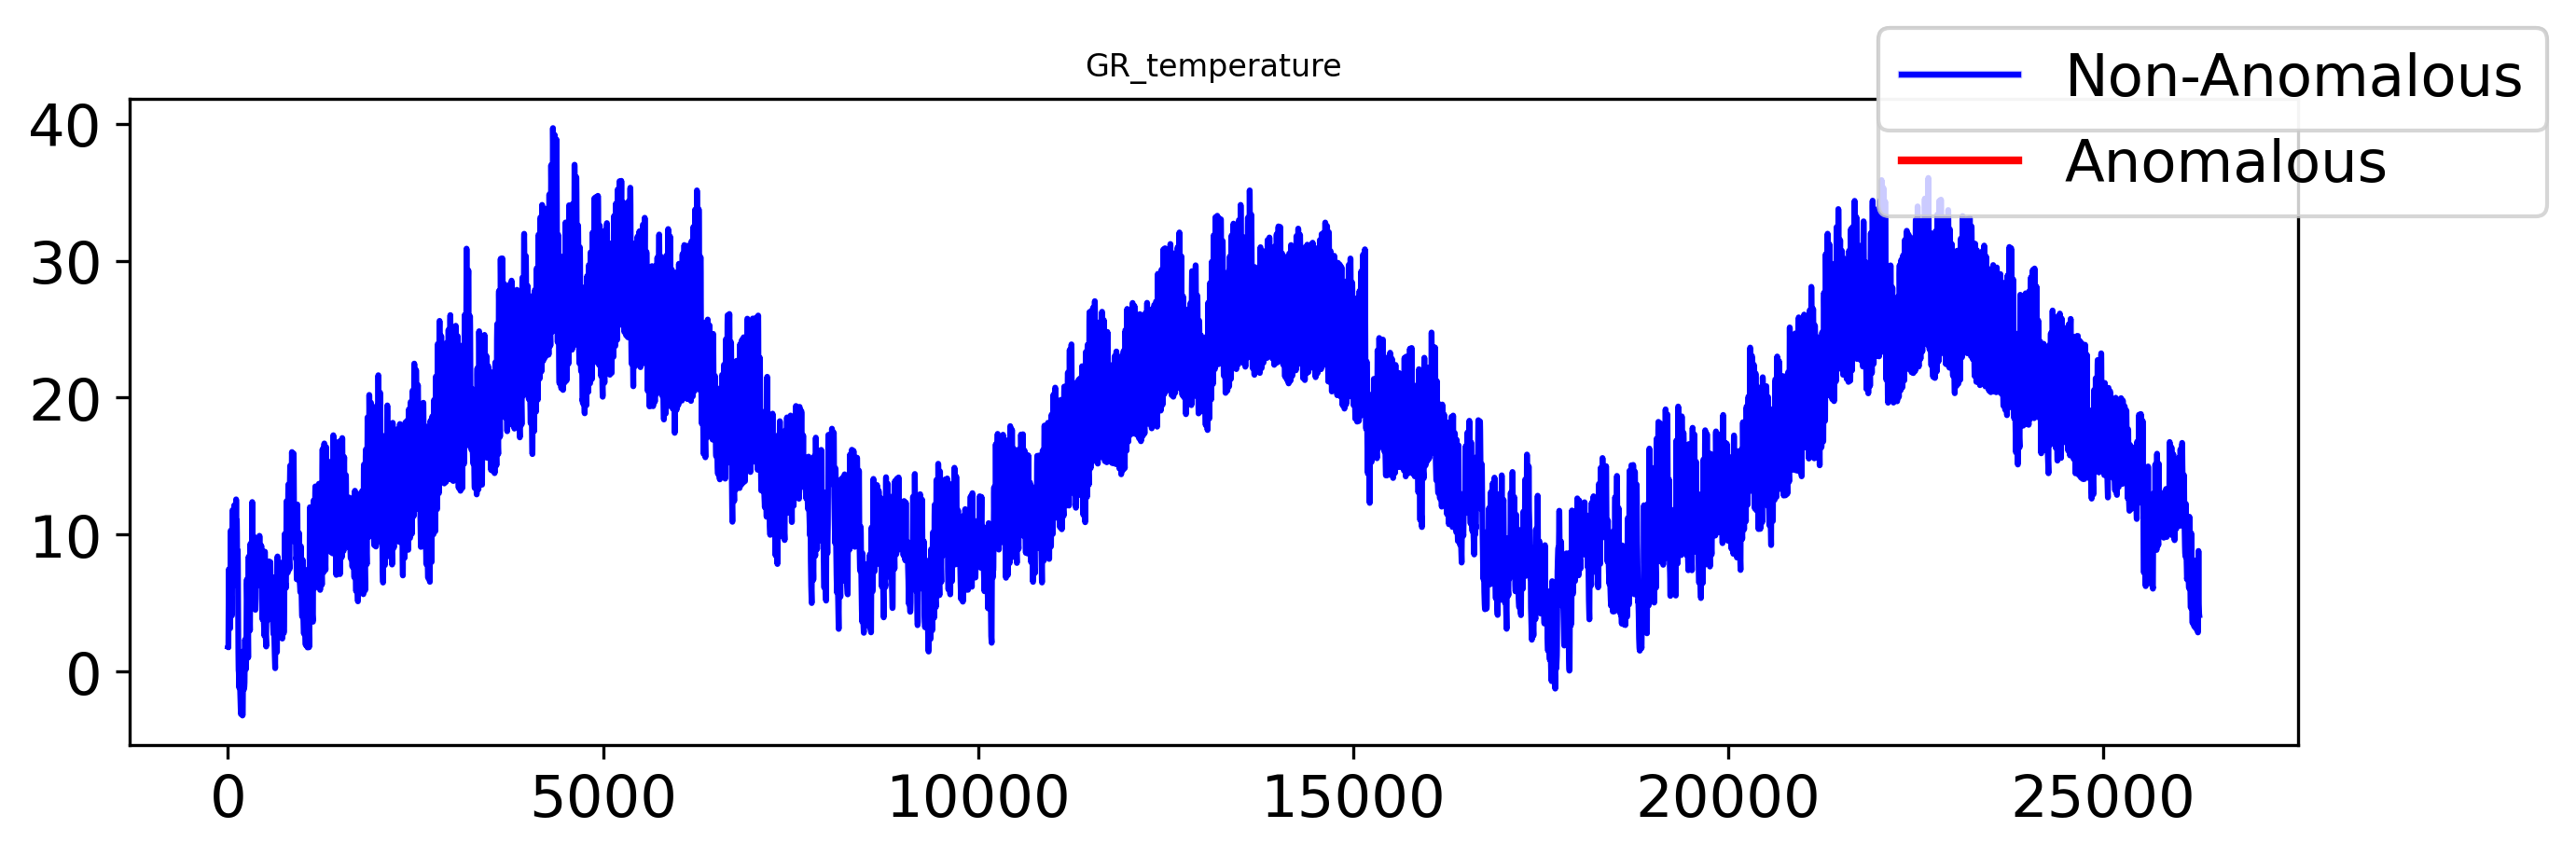

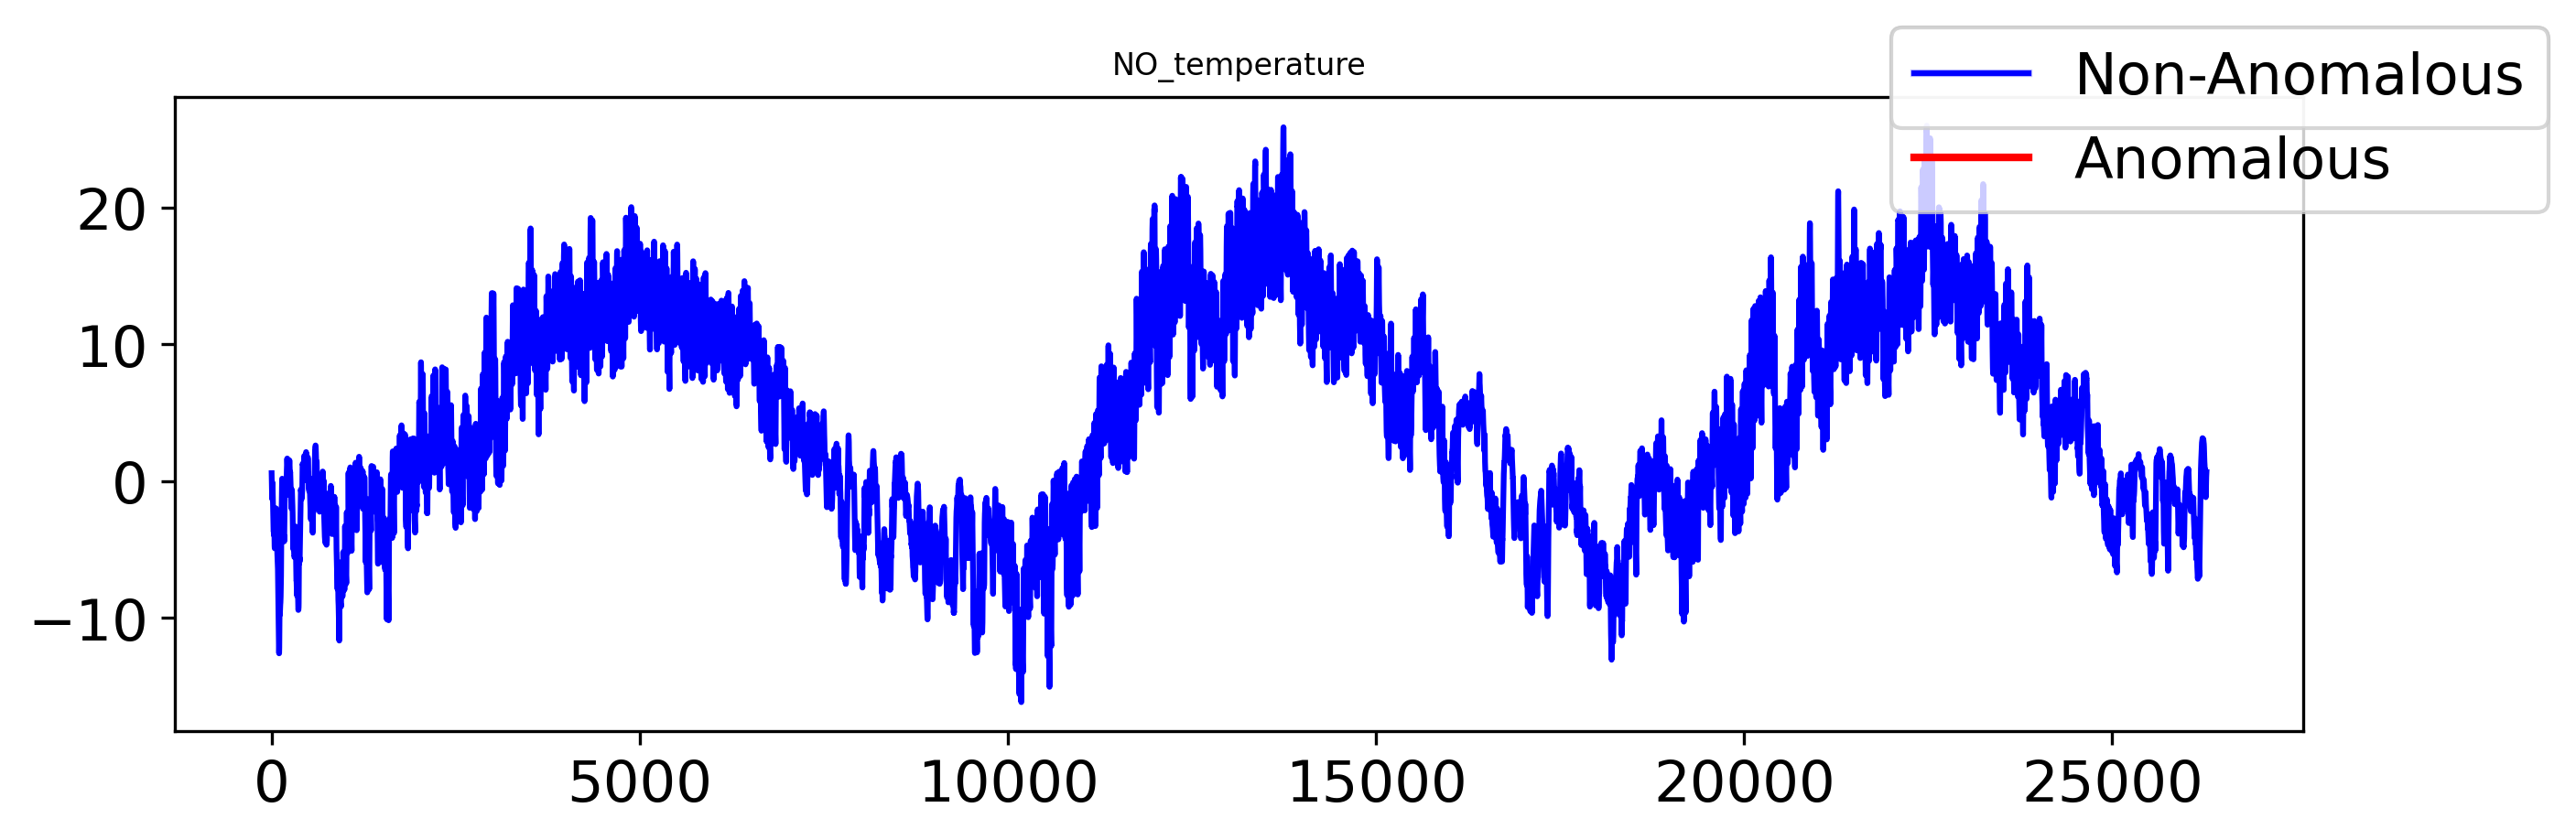

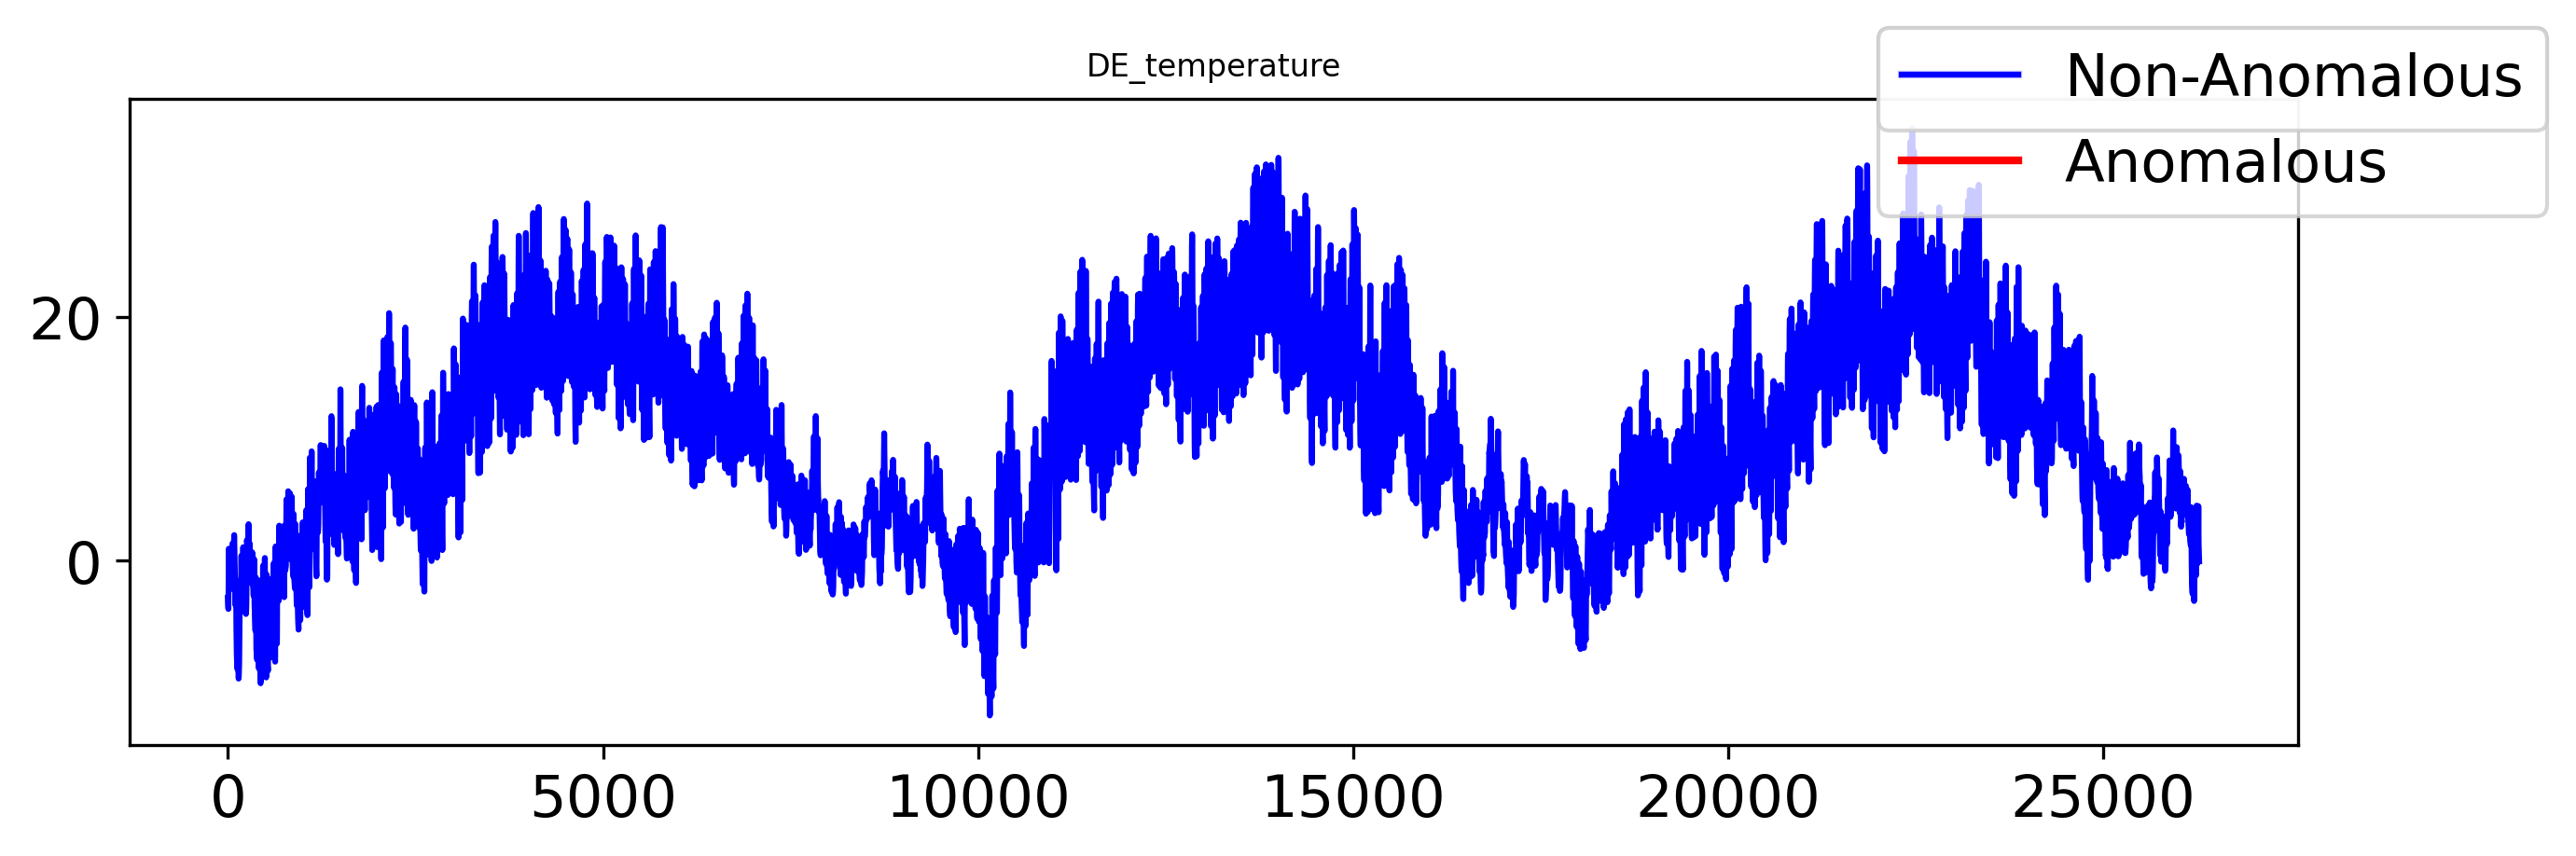

In [3]:
## Portugal, Greece, Norway, Germany
selected_files = config_param['source_files']
dir = config_param['source_dir']
WeatherStreams = []
for i, file in enumerate(selected_files):
    WeatherStreams.append(Stream(f"{dir}/{file}_temperature.arff"))
    WeatherStreams[i].plot()

### Injecting anomalies into the selected streams

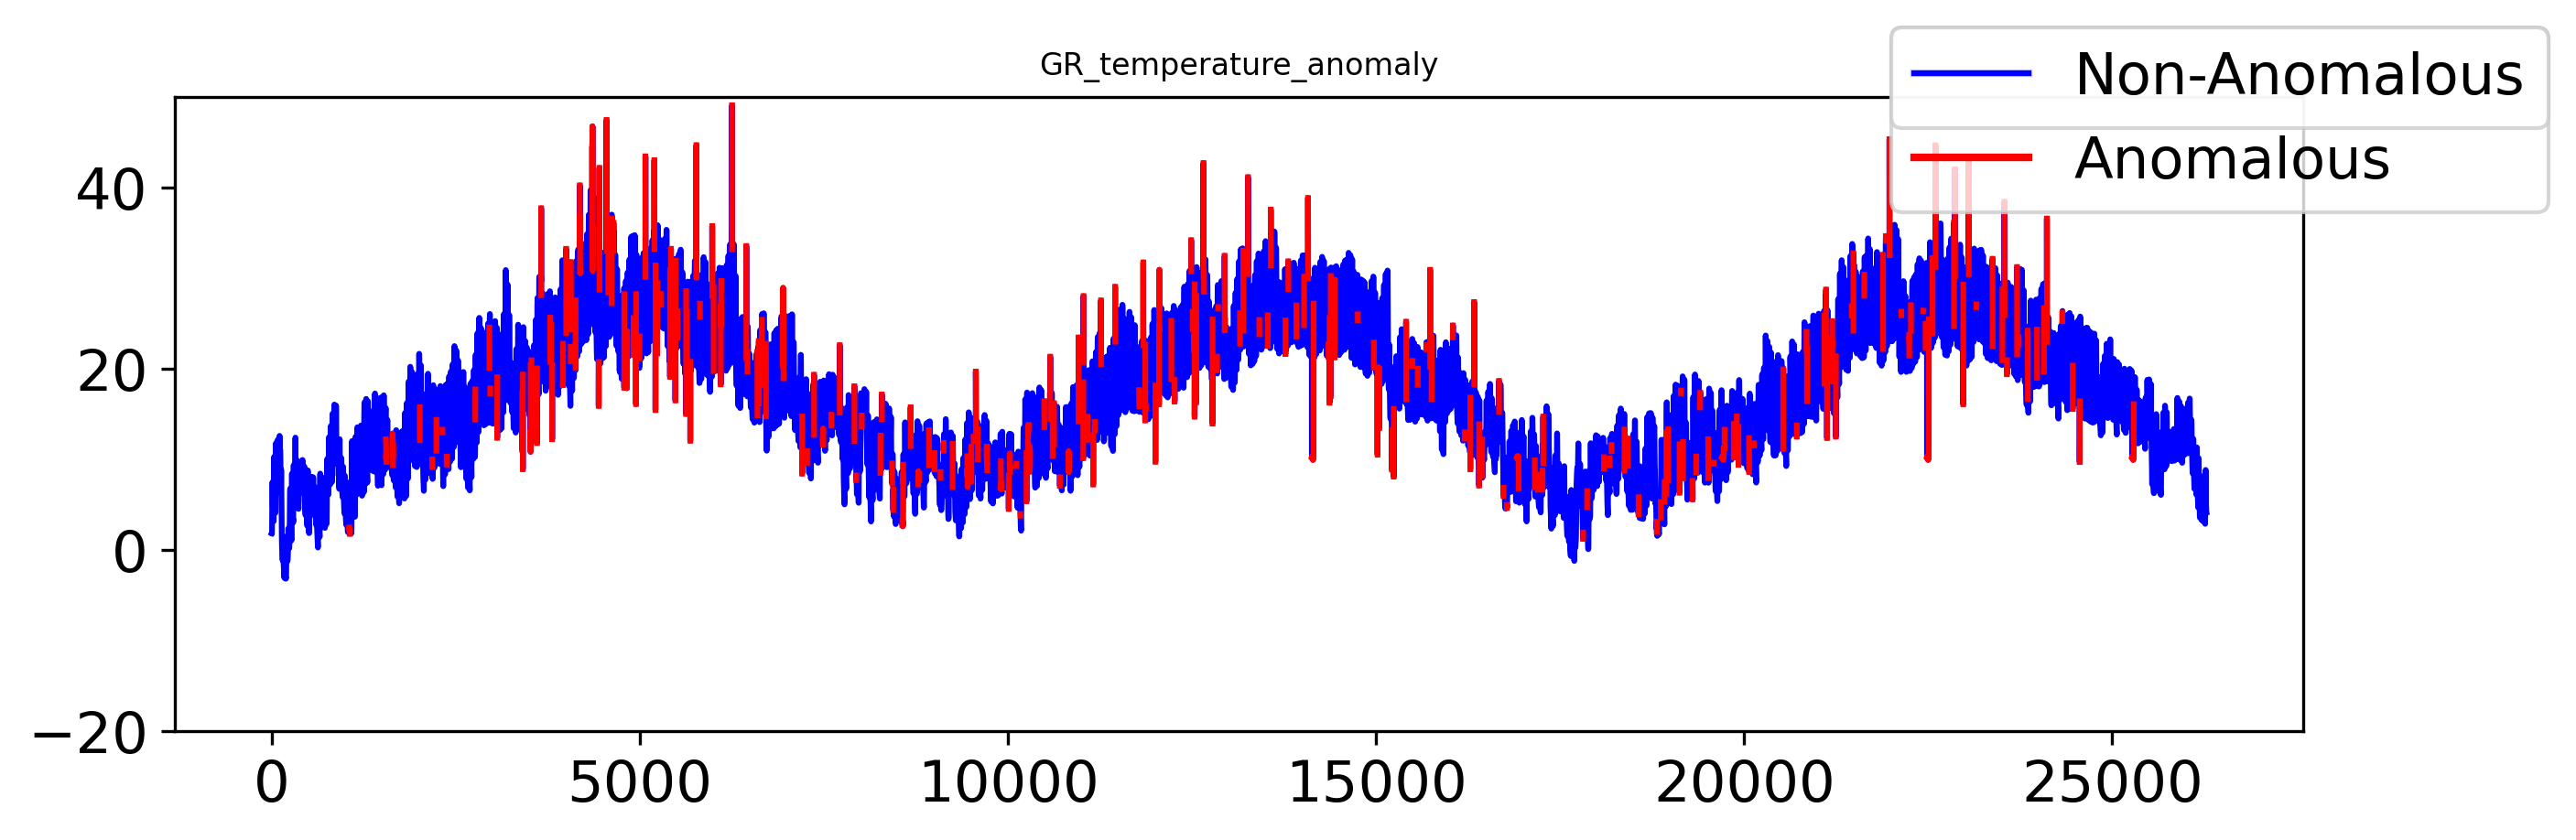

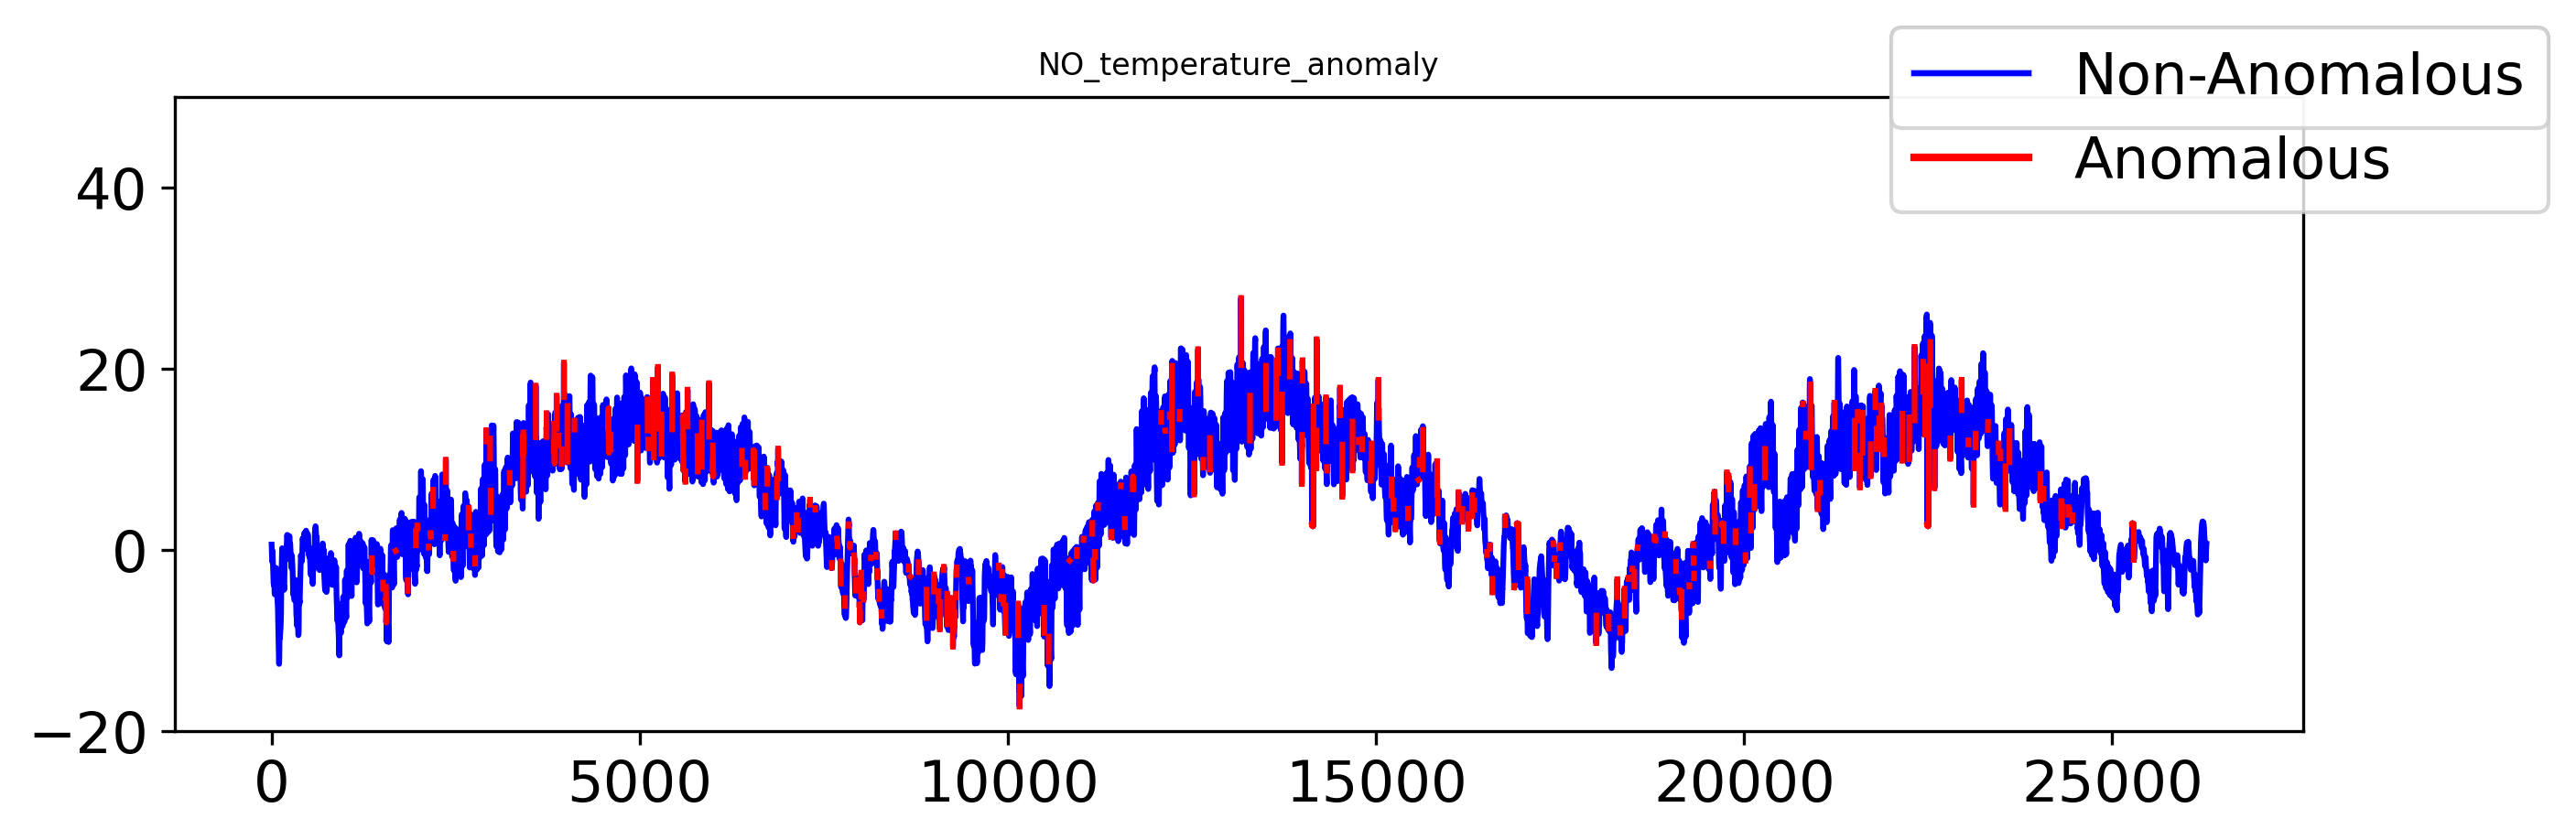

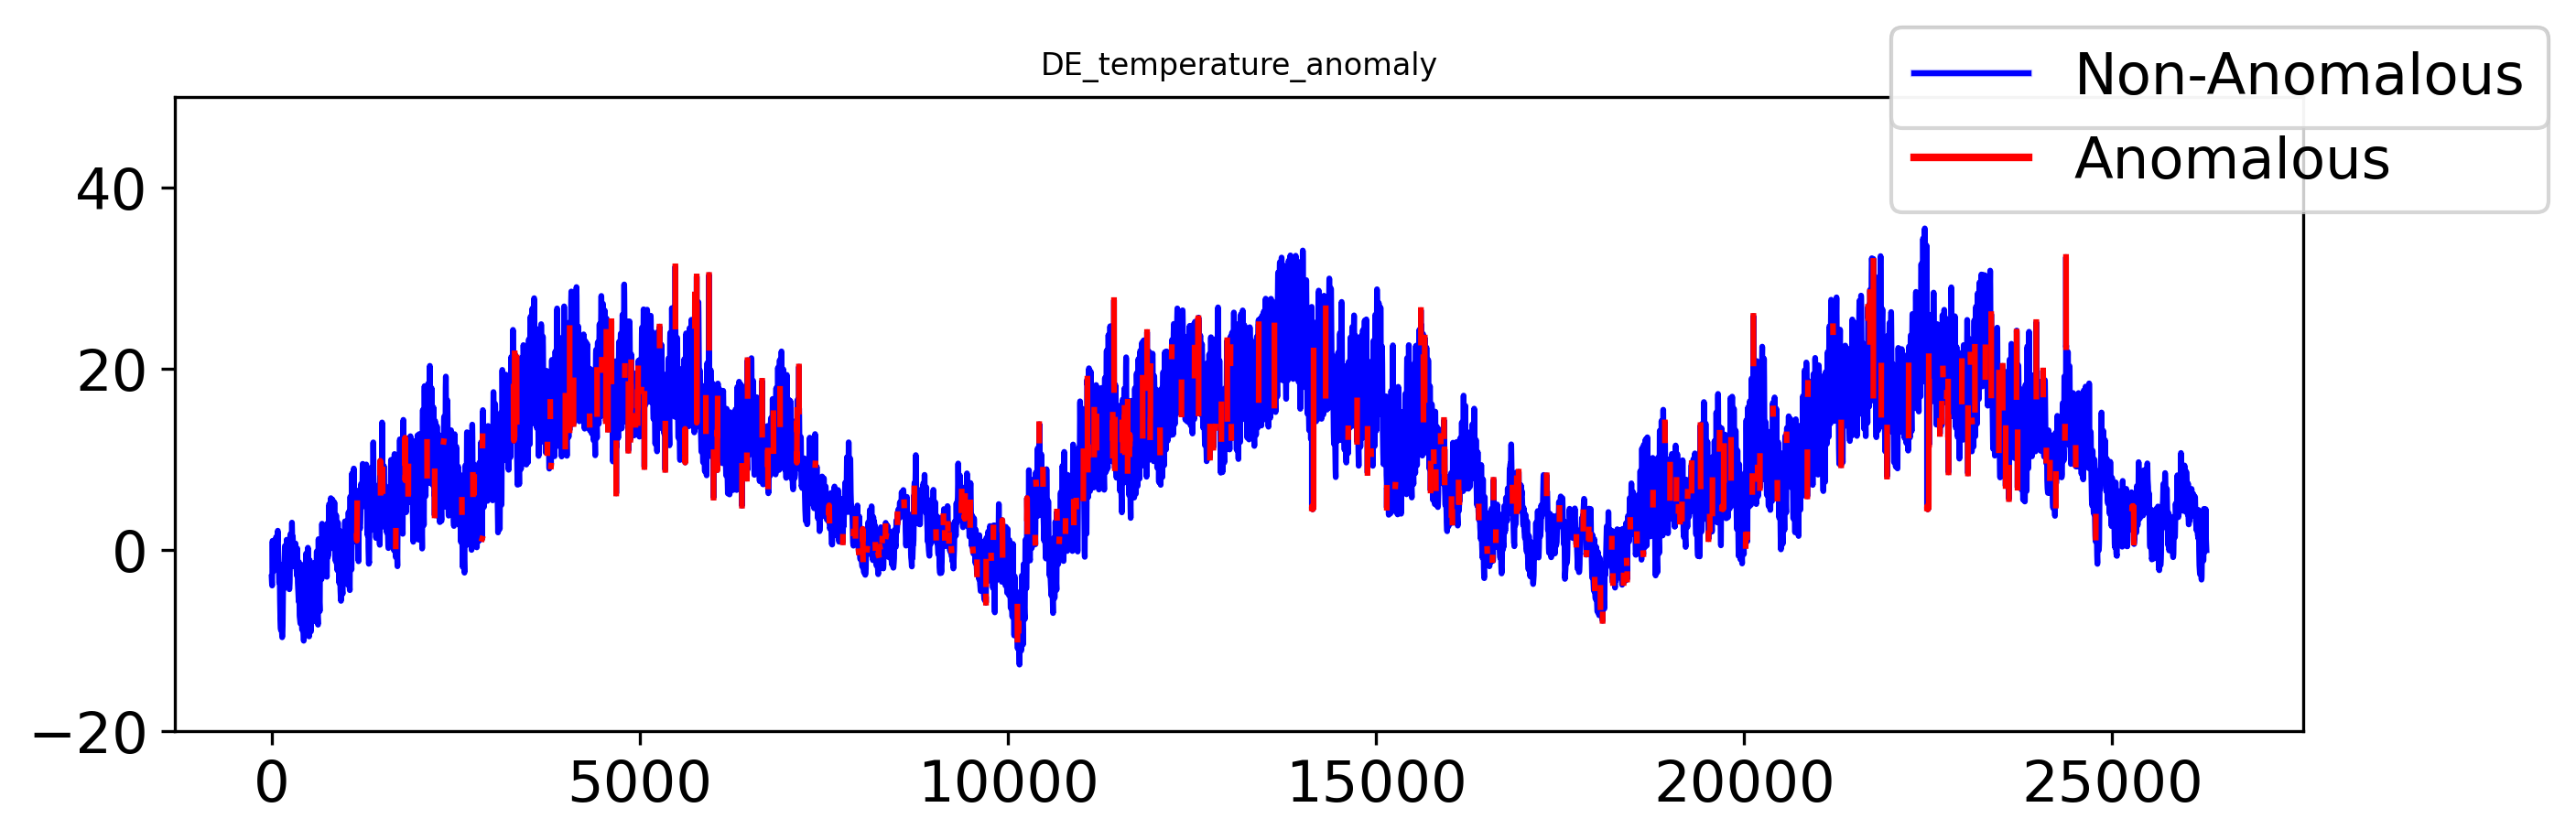

In [4]:
WeatherAnomalies = []
for i, WeatherStream in enumerate(WeatherStreams):
    # creating intervals within the stream in or
    WeatherAnomalies.append(createAnomalyIntervals(WeatherStream))
    # IMPORTANT NOTE: gap size cannot exceed 1/2 interval size (no anomalies will be injected as interval size will be nonexistent)
    # creating 3 equally size intervals to inject anomalies into the dataset
    WeatherAnomalies[i] = add_anomalies(WeatherAnomalies[i], config_param)

    ## Save anomaly injected steream into .arff file 
    WeatherStream.filename = f"{WeatherStream.filename}_anomaly"
    WeatherStream.to_arff(f"{dir}")
    
    WeatherStream.plot()
    plt.ylim([-20, 50])

### For plotting only

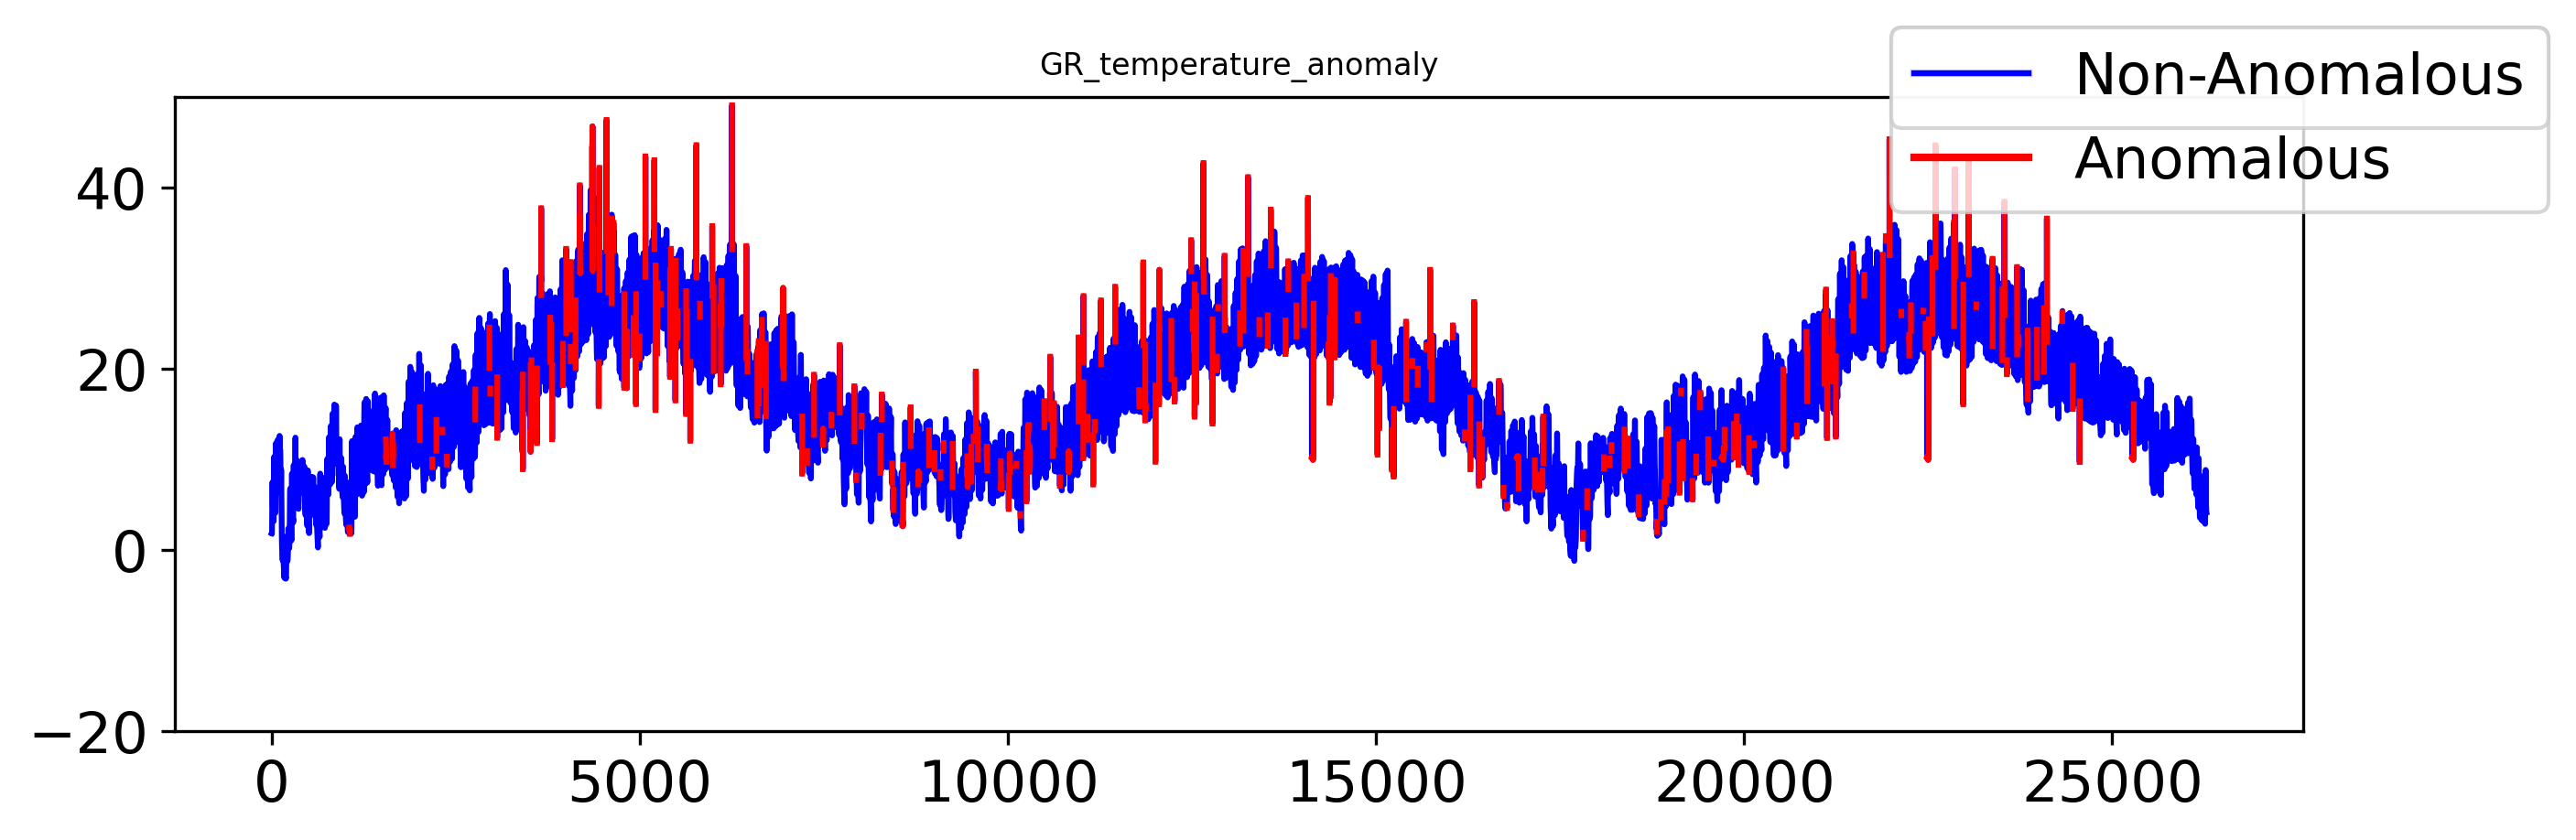

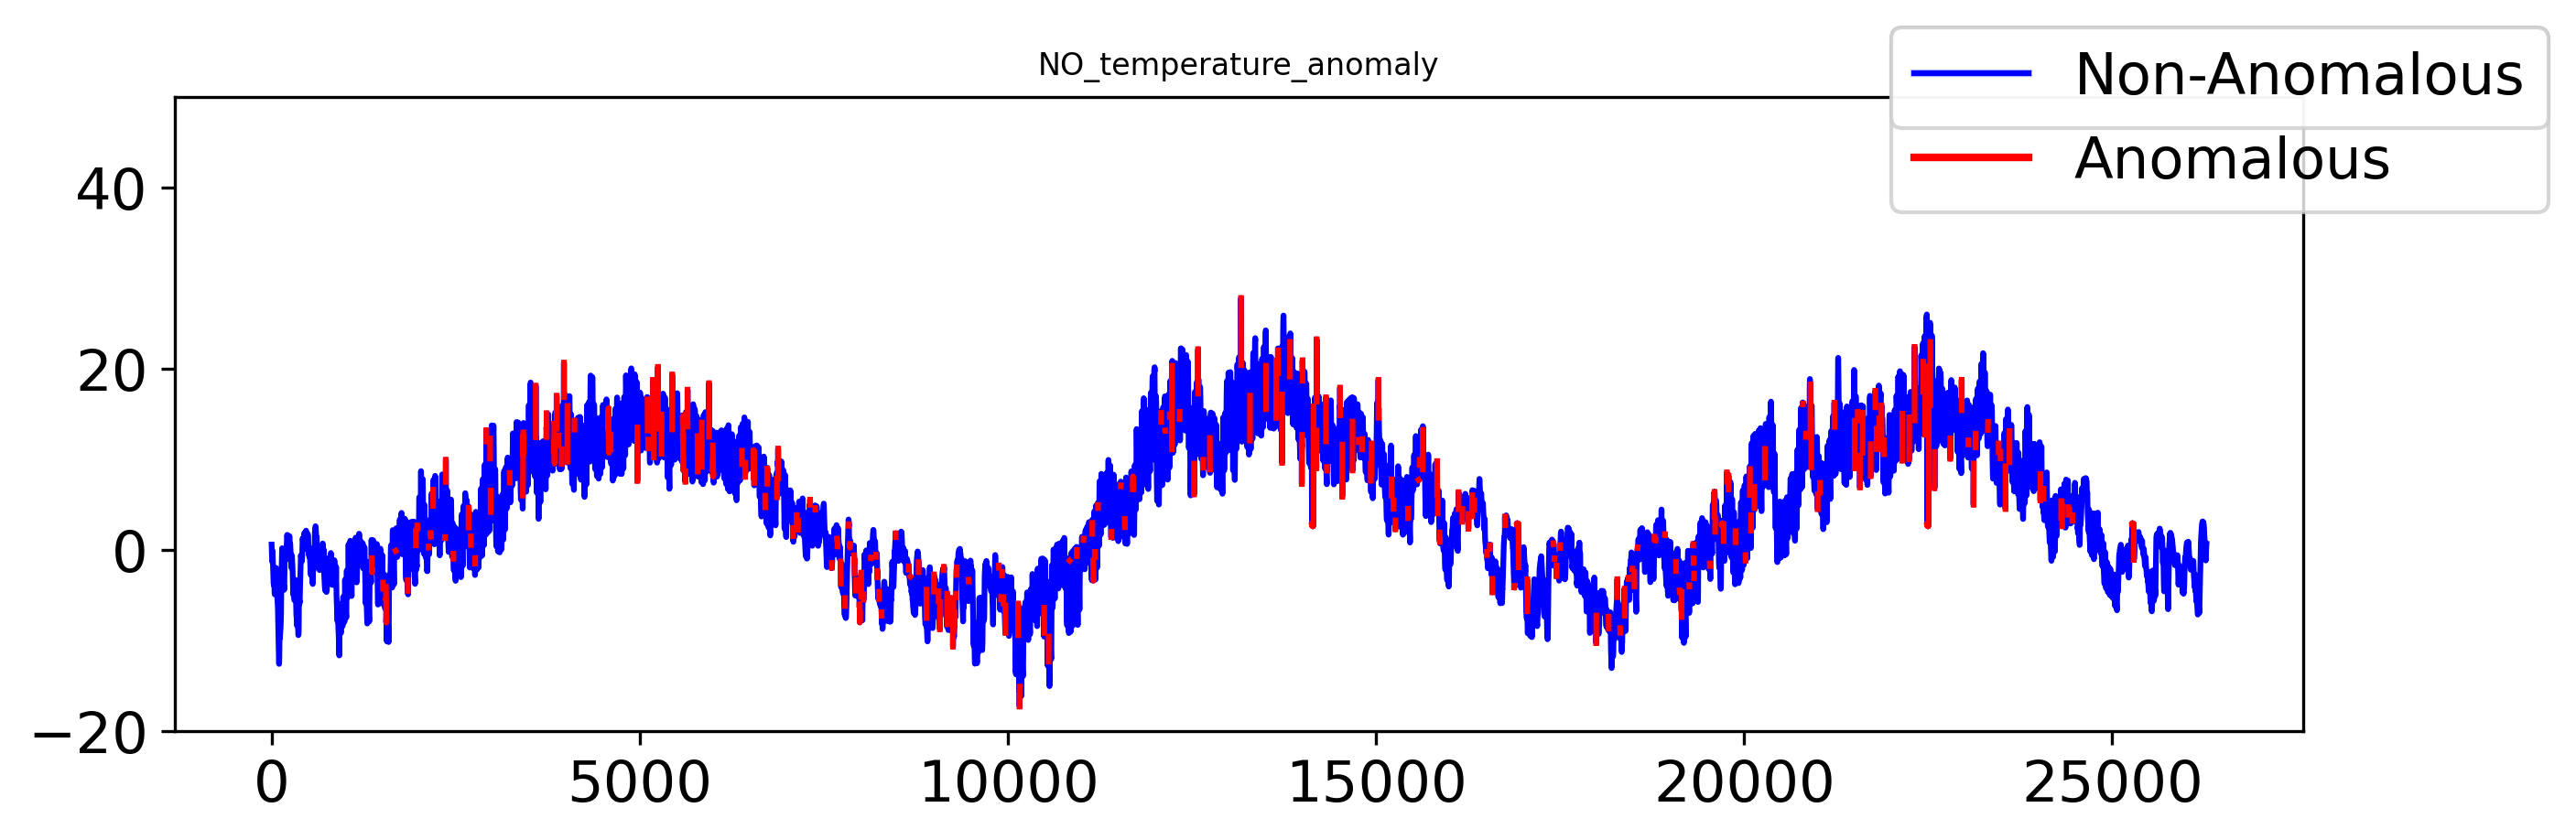

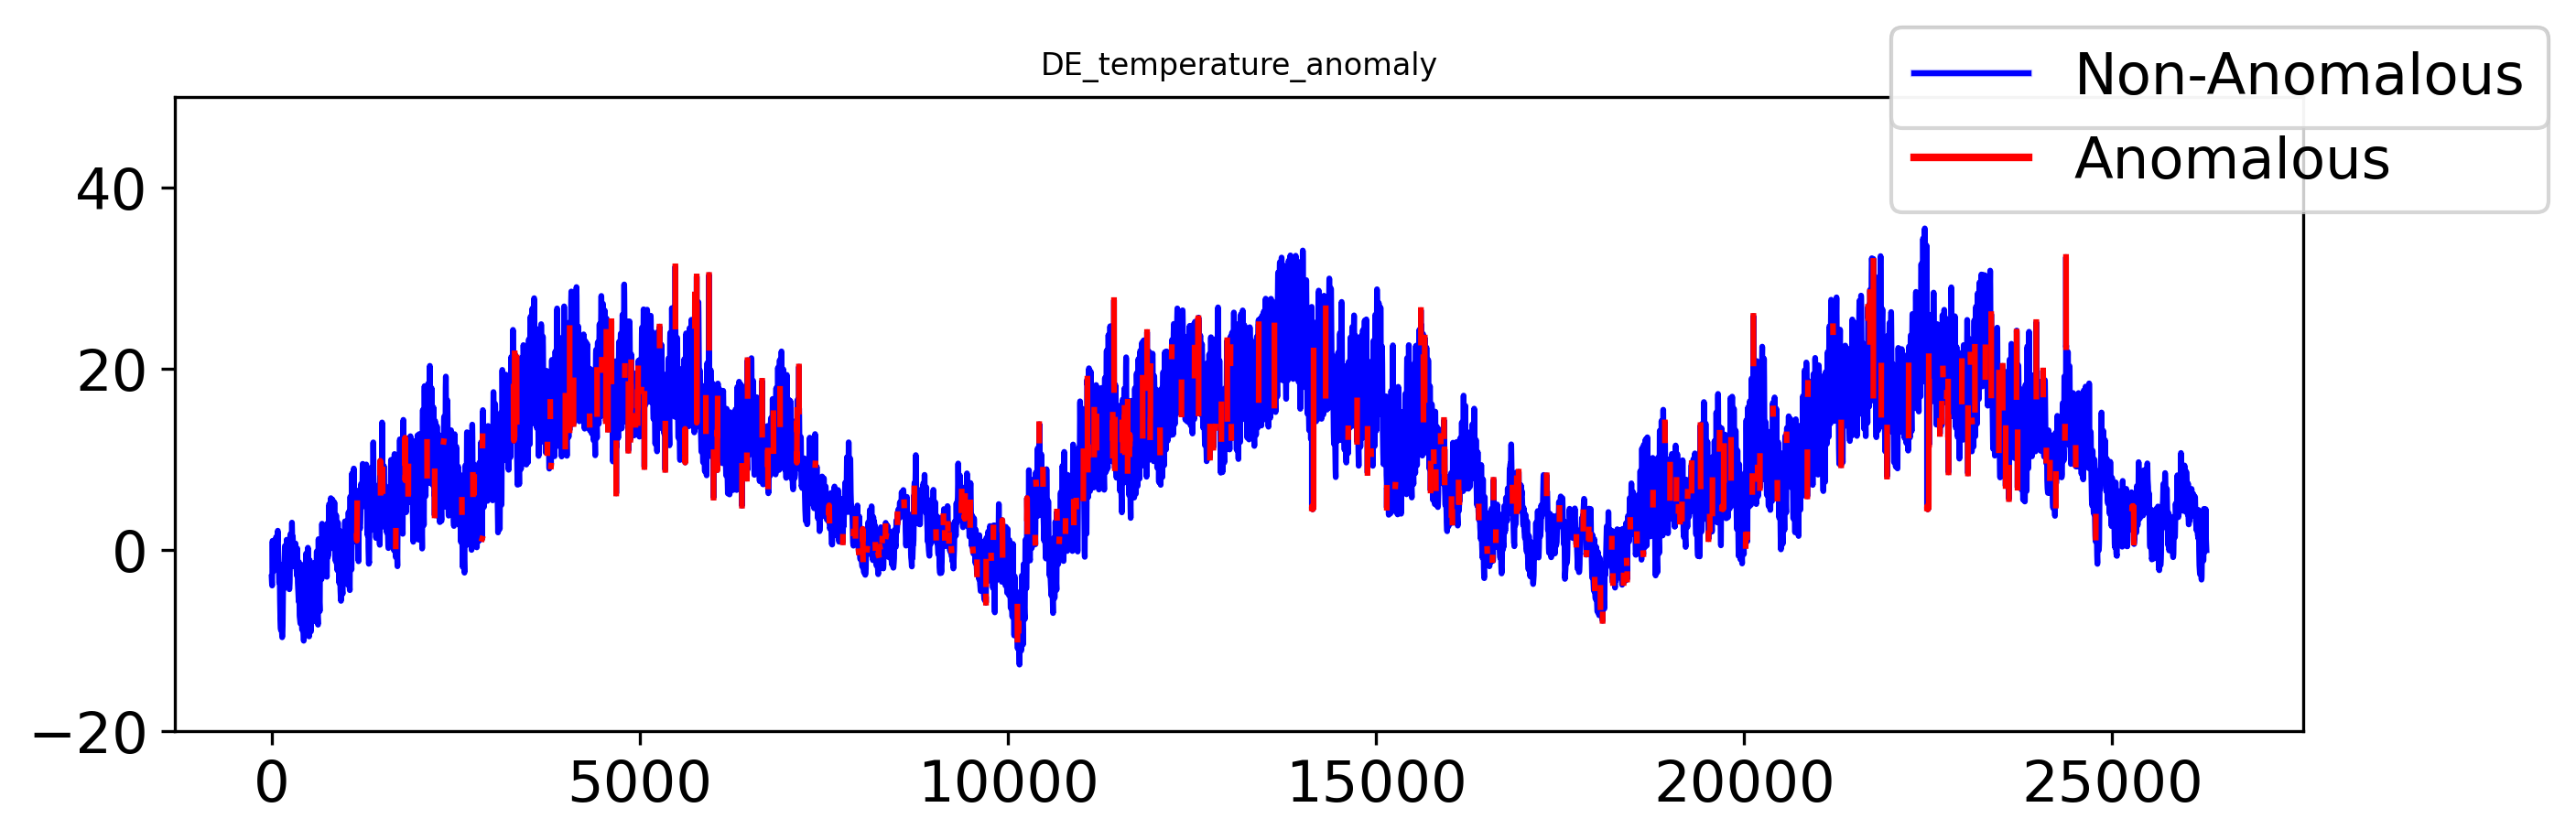

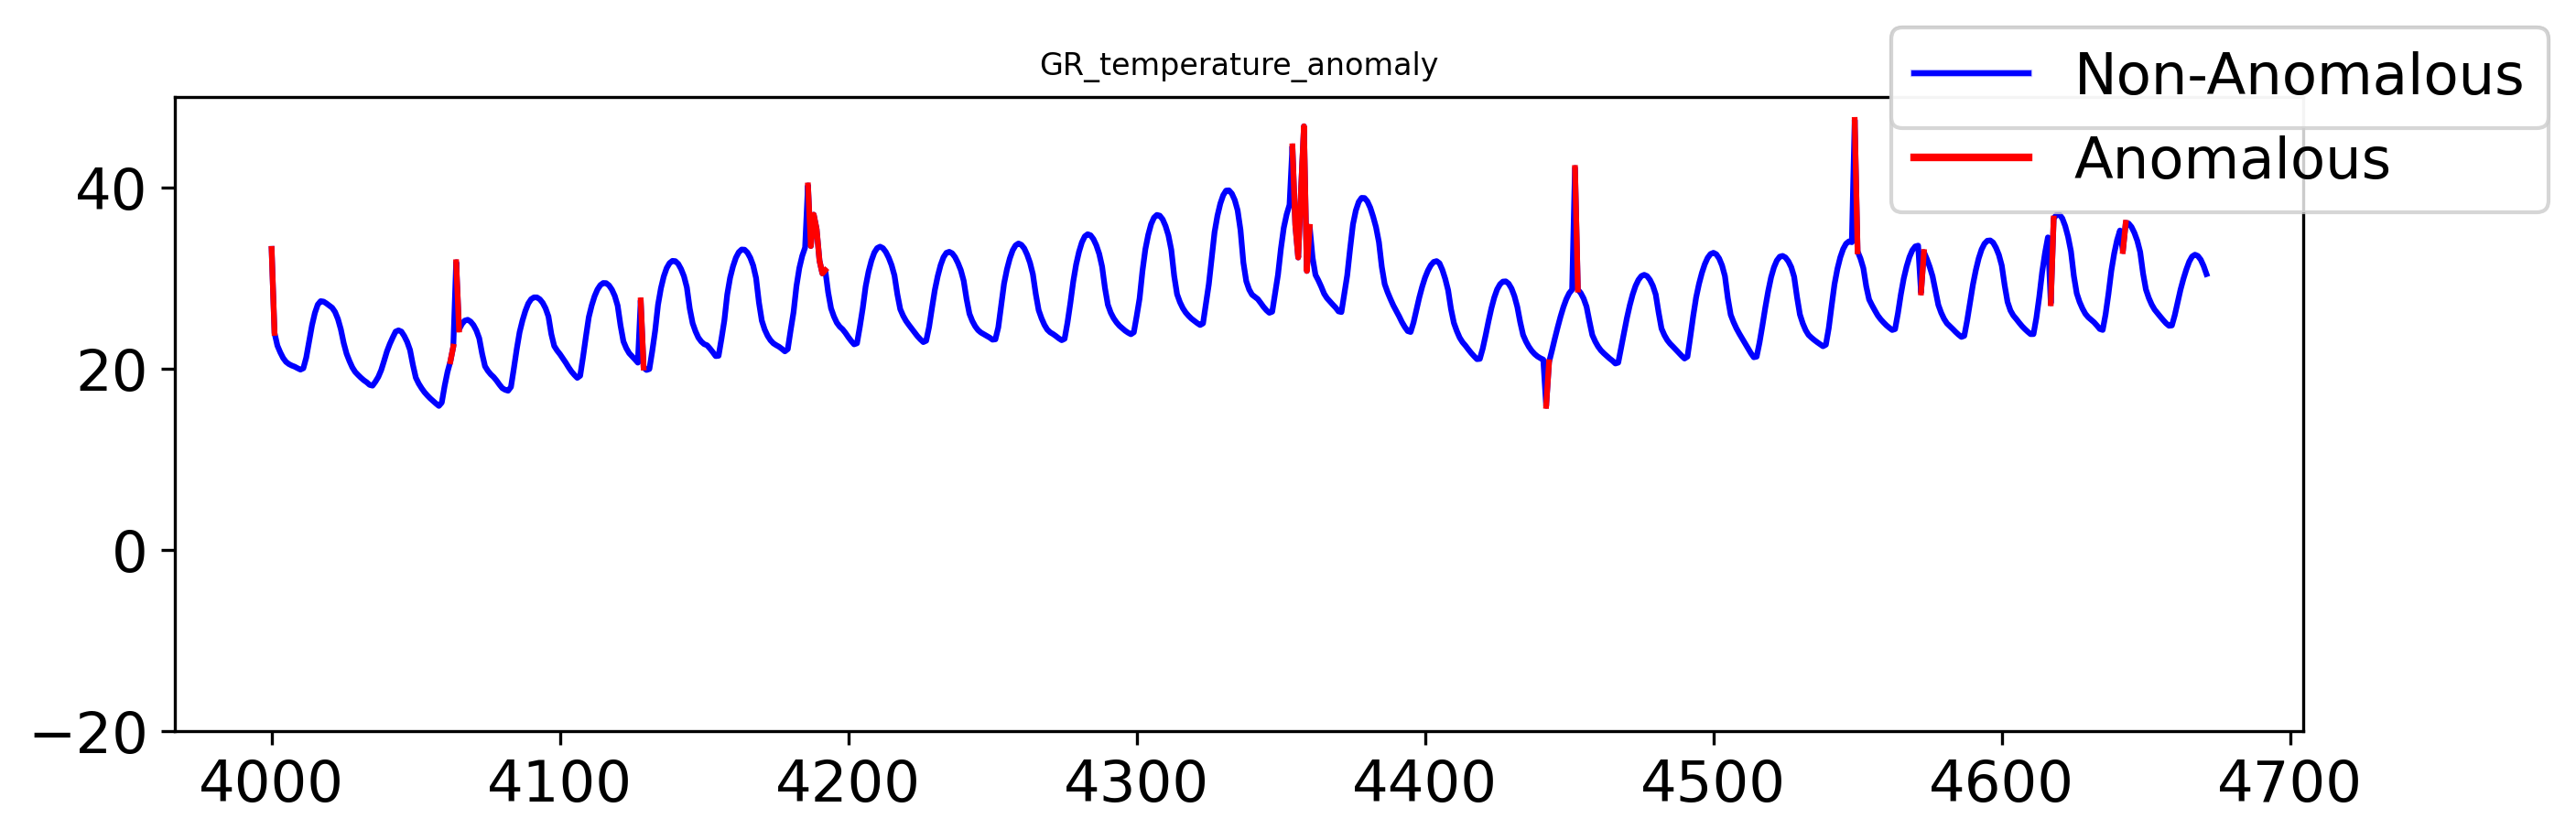

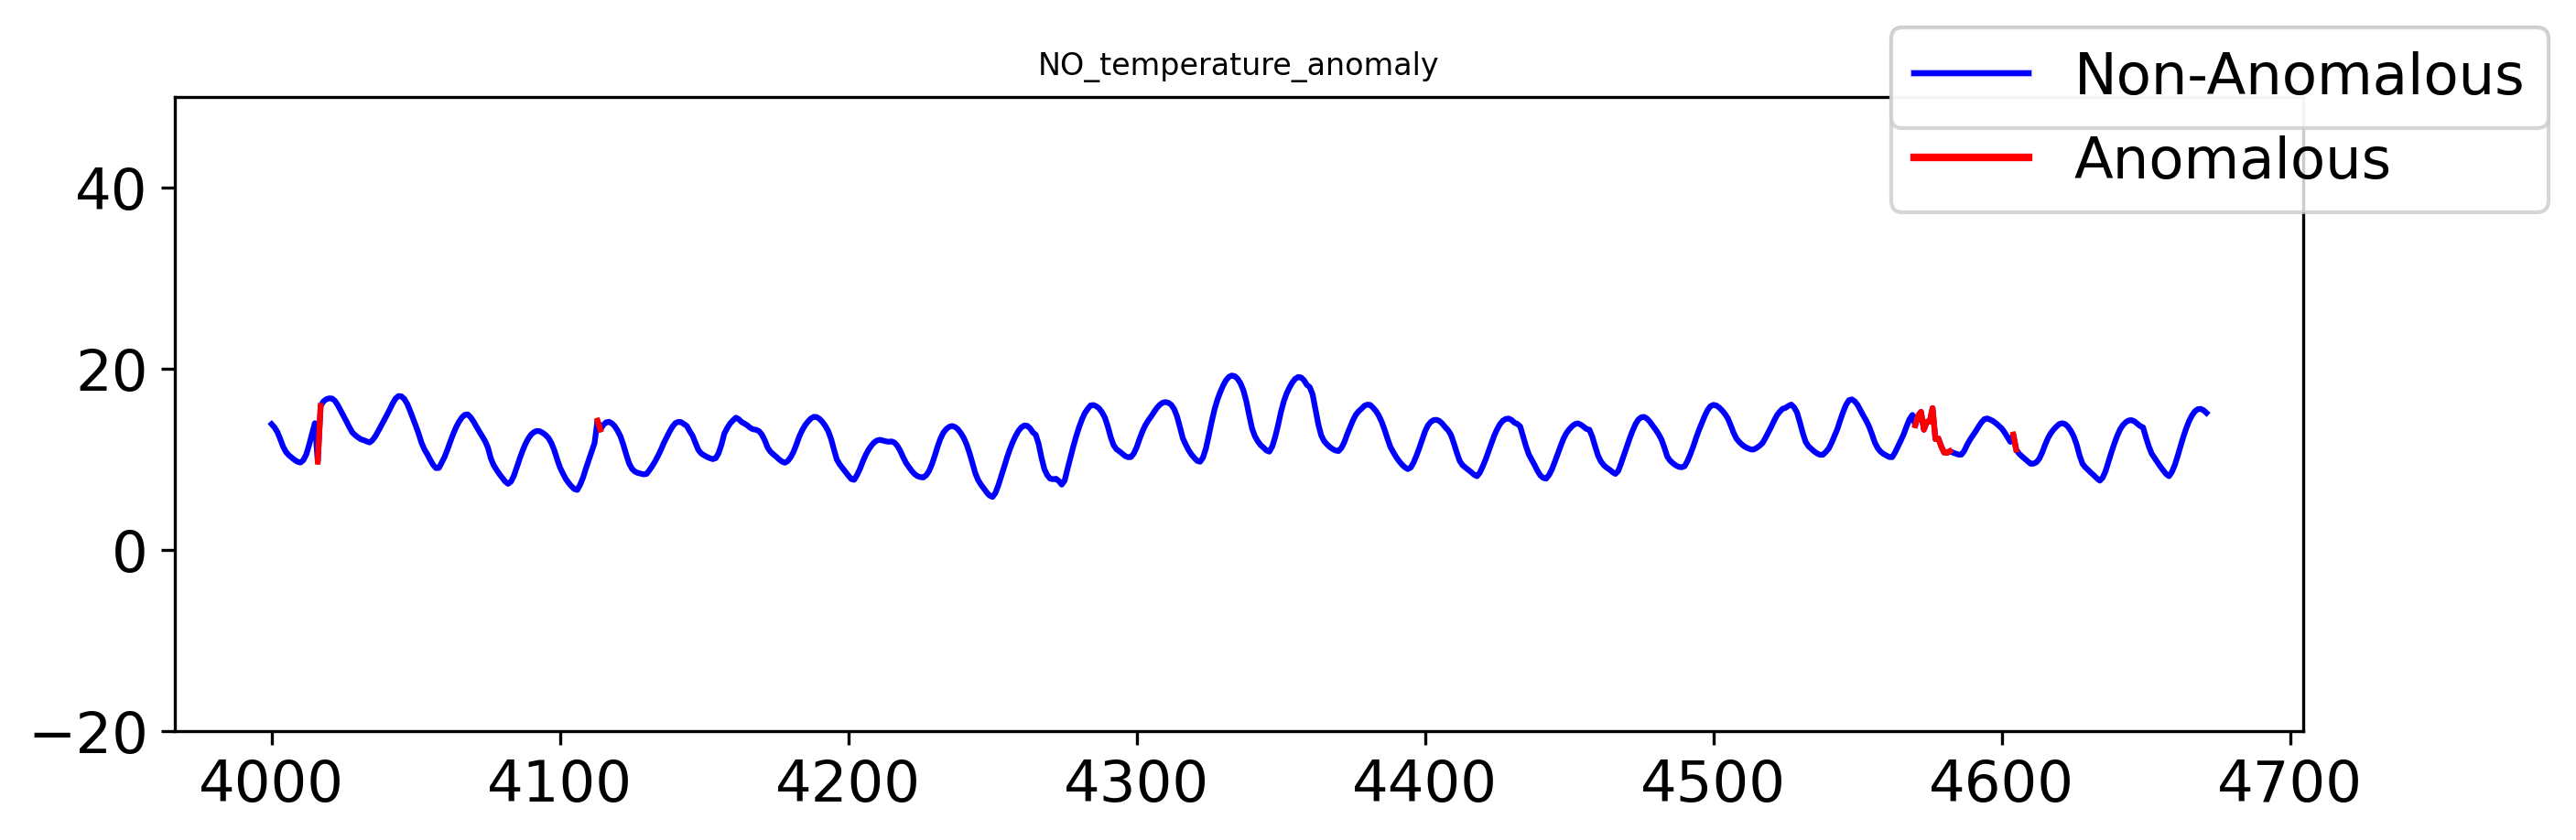

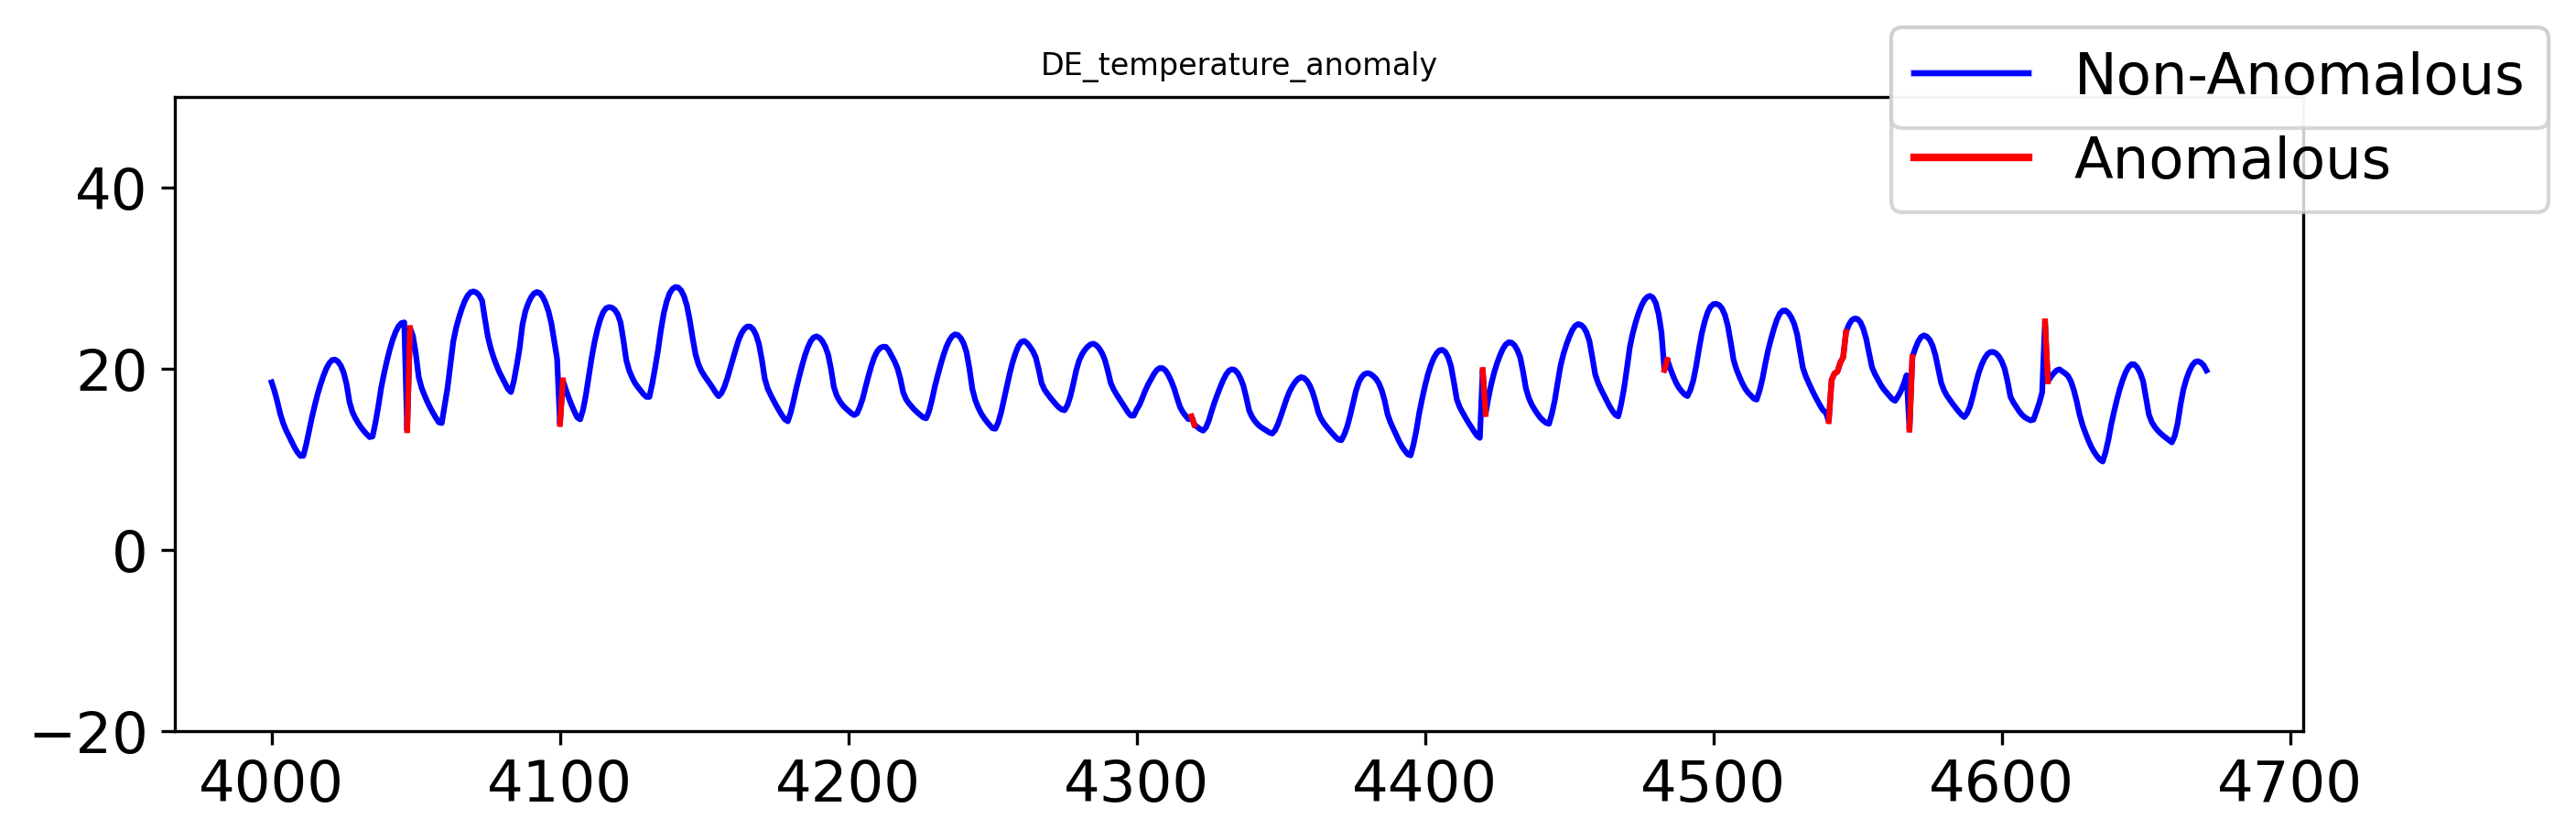

In [5]:
for WeatherAnomaly, WeatherStream in zip(WeatherAnomalies, WeatherStreams):
    WeatherStream.plot()
    plt.ylim([-20, 50])
for WeatherAnomaly, WeatherStream in zip(WeatherAnomalies, WeatherStreams):
    WeatherStream.plot(4000,4000+24*28)
    plt.ylim([-20, 50])

### For Drift

Generating splits...
	Getting partitions...
	Getting order of drifts coming before anomaly...
	Getting drift center positions...
	Getting stream file cuts...
Done!
Getting stream file cuts...	Done!
Creating intermediate files...	Done!
Recursively generating MOA command...	Done!
Drift filename:  Weather_grad_p0_n5_b0
Running terminal command...	


{M}assive {O}nline {A}nalysis
Version:  23.04 April 2023
Copyright: (C) 2007-2023 University of Waikato, Hamilton, New Zealand
Web: http://moa.cms.waikato.ac.nz/

                                                                               
Task completed in 0.25s (CPU time)



Stream written to ARFF file /Users/jongjunPark/Research-timeSeries/AnomalyDriftDetection-main/data/synthetic/demo/Weather_grad_p0_n5_b0.arff
Done!
Generating drift labels...	Done!


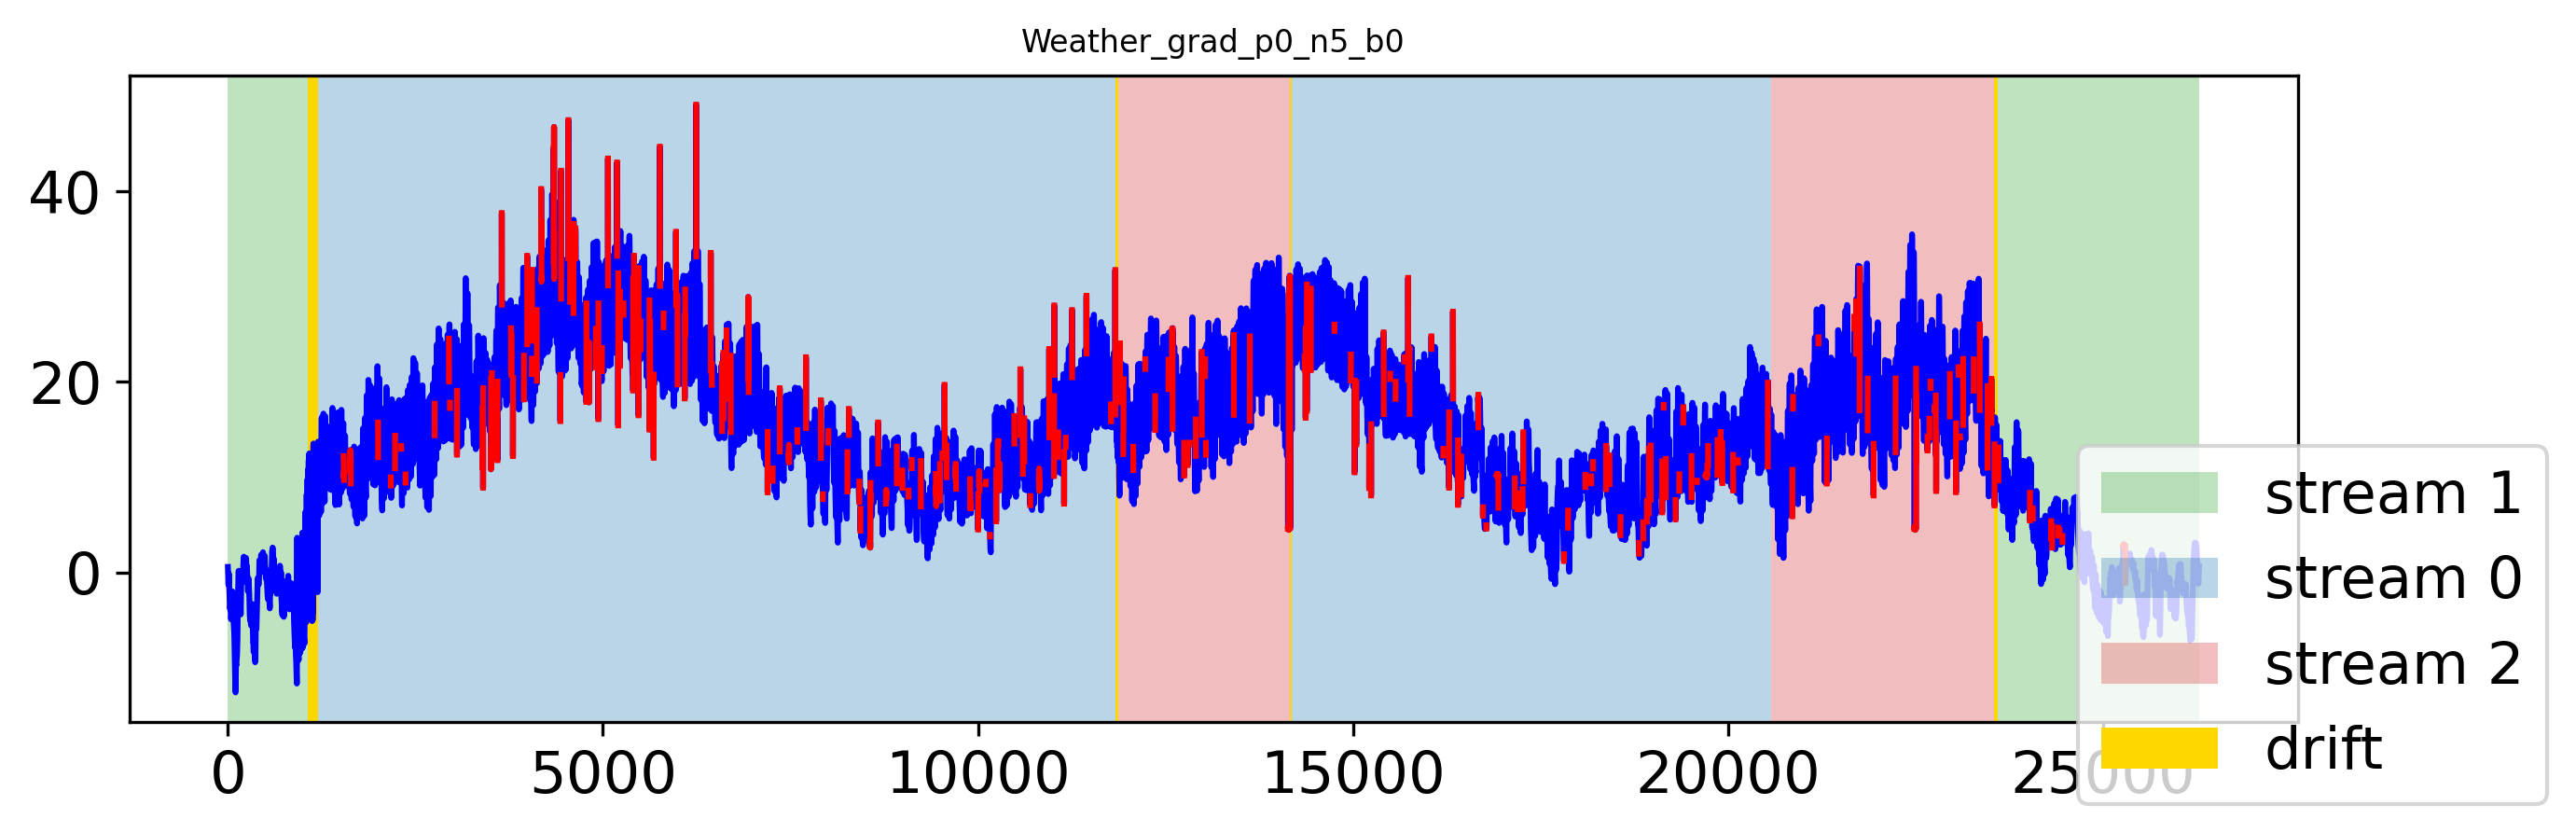

In [6]:
moa_path = config_param['moa_path']
source_streams = WeatherStreams
drift_dir = os.getcwd()+ config_param['drift_dir']
g = DriftGenerator(dir, drift_dir, moa_path, selected_streams=source_streams)

length = WeatherStreams[0].length
dataset = 'Weather'

ds = g.run_generate_grad_stream_moa(
    length=length,
    dataset = dataset,
    mode=0,  # 0 for variable drift widths and positions, 1 for uniform
    **config_param['drift_params']
)

ds.plot_drift()

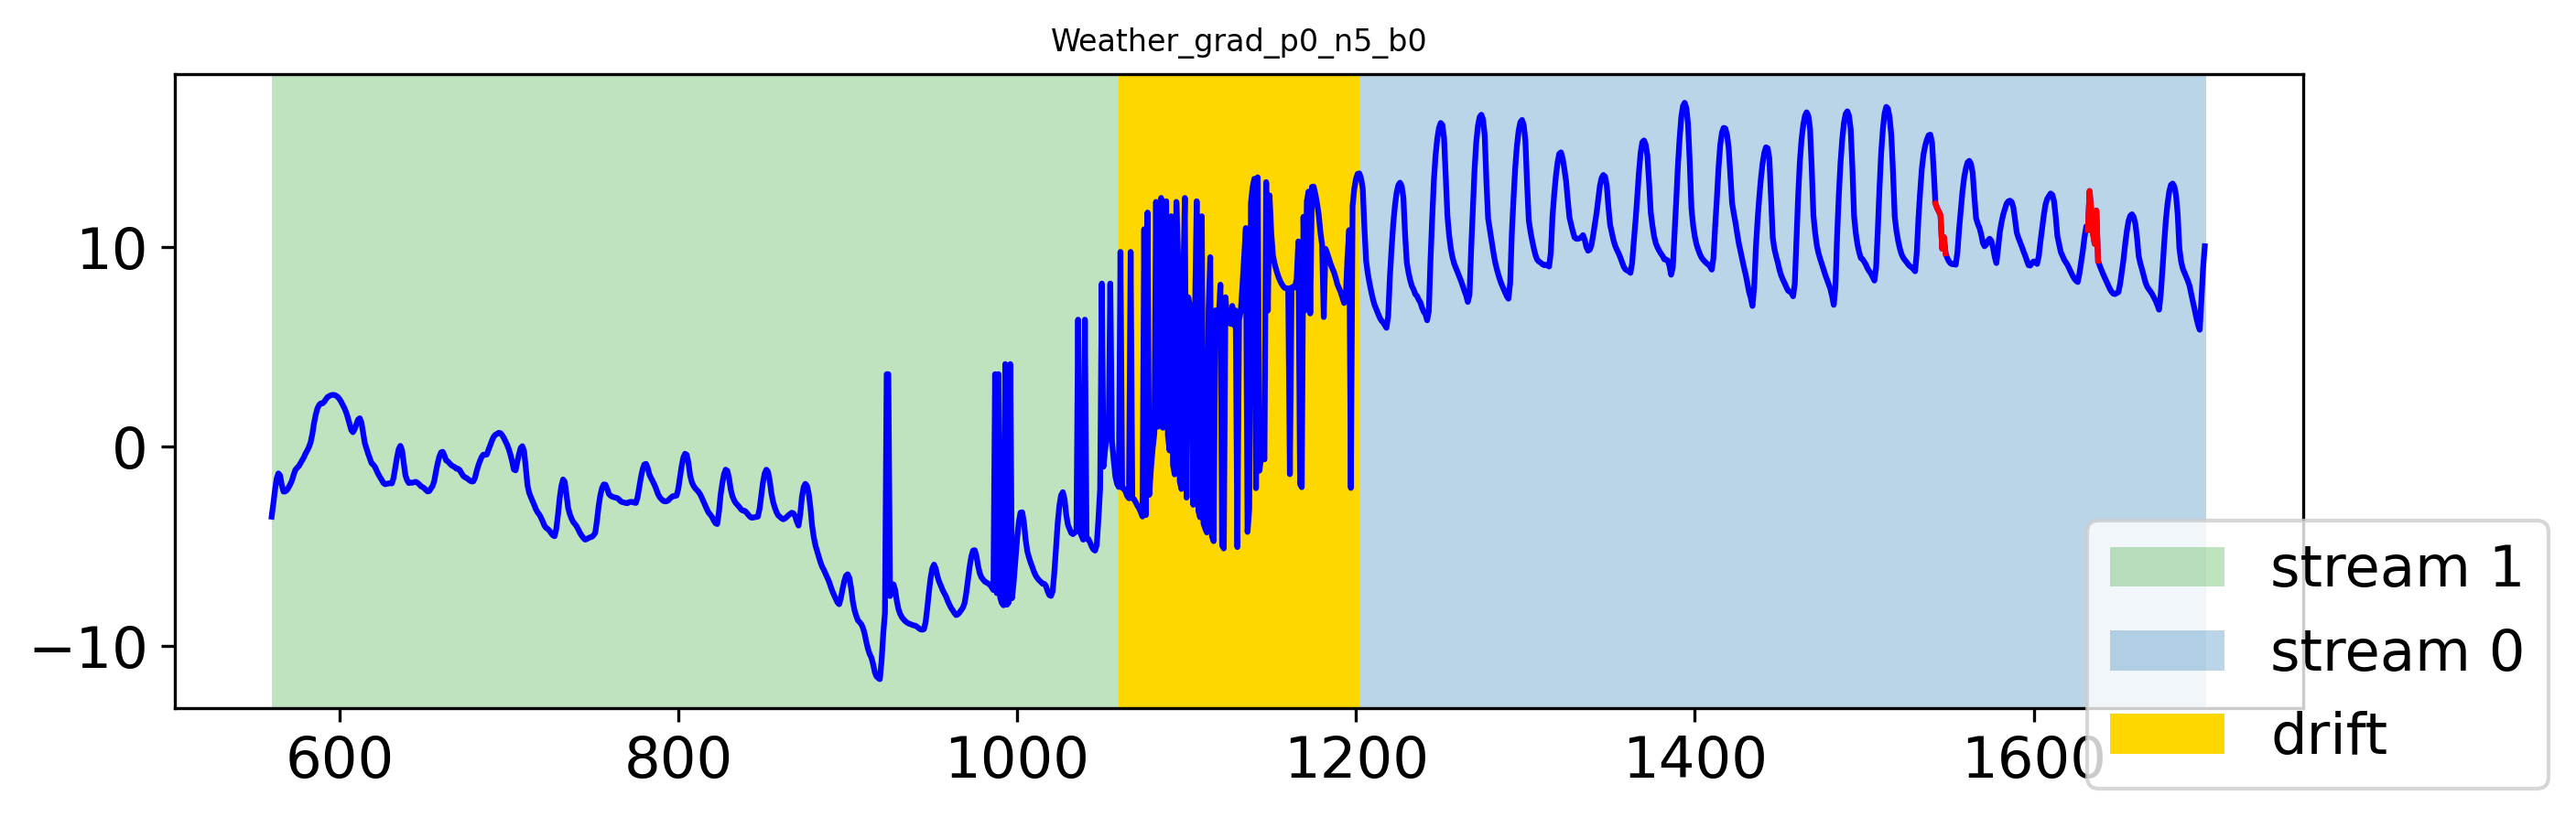

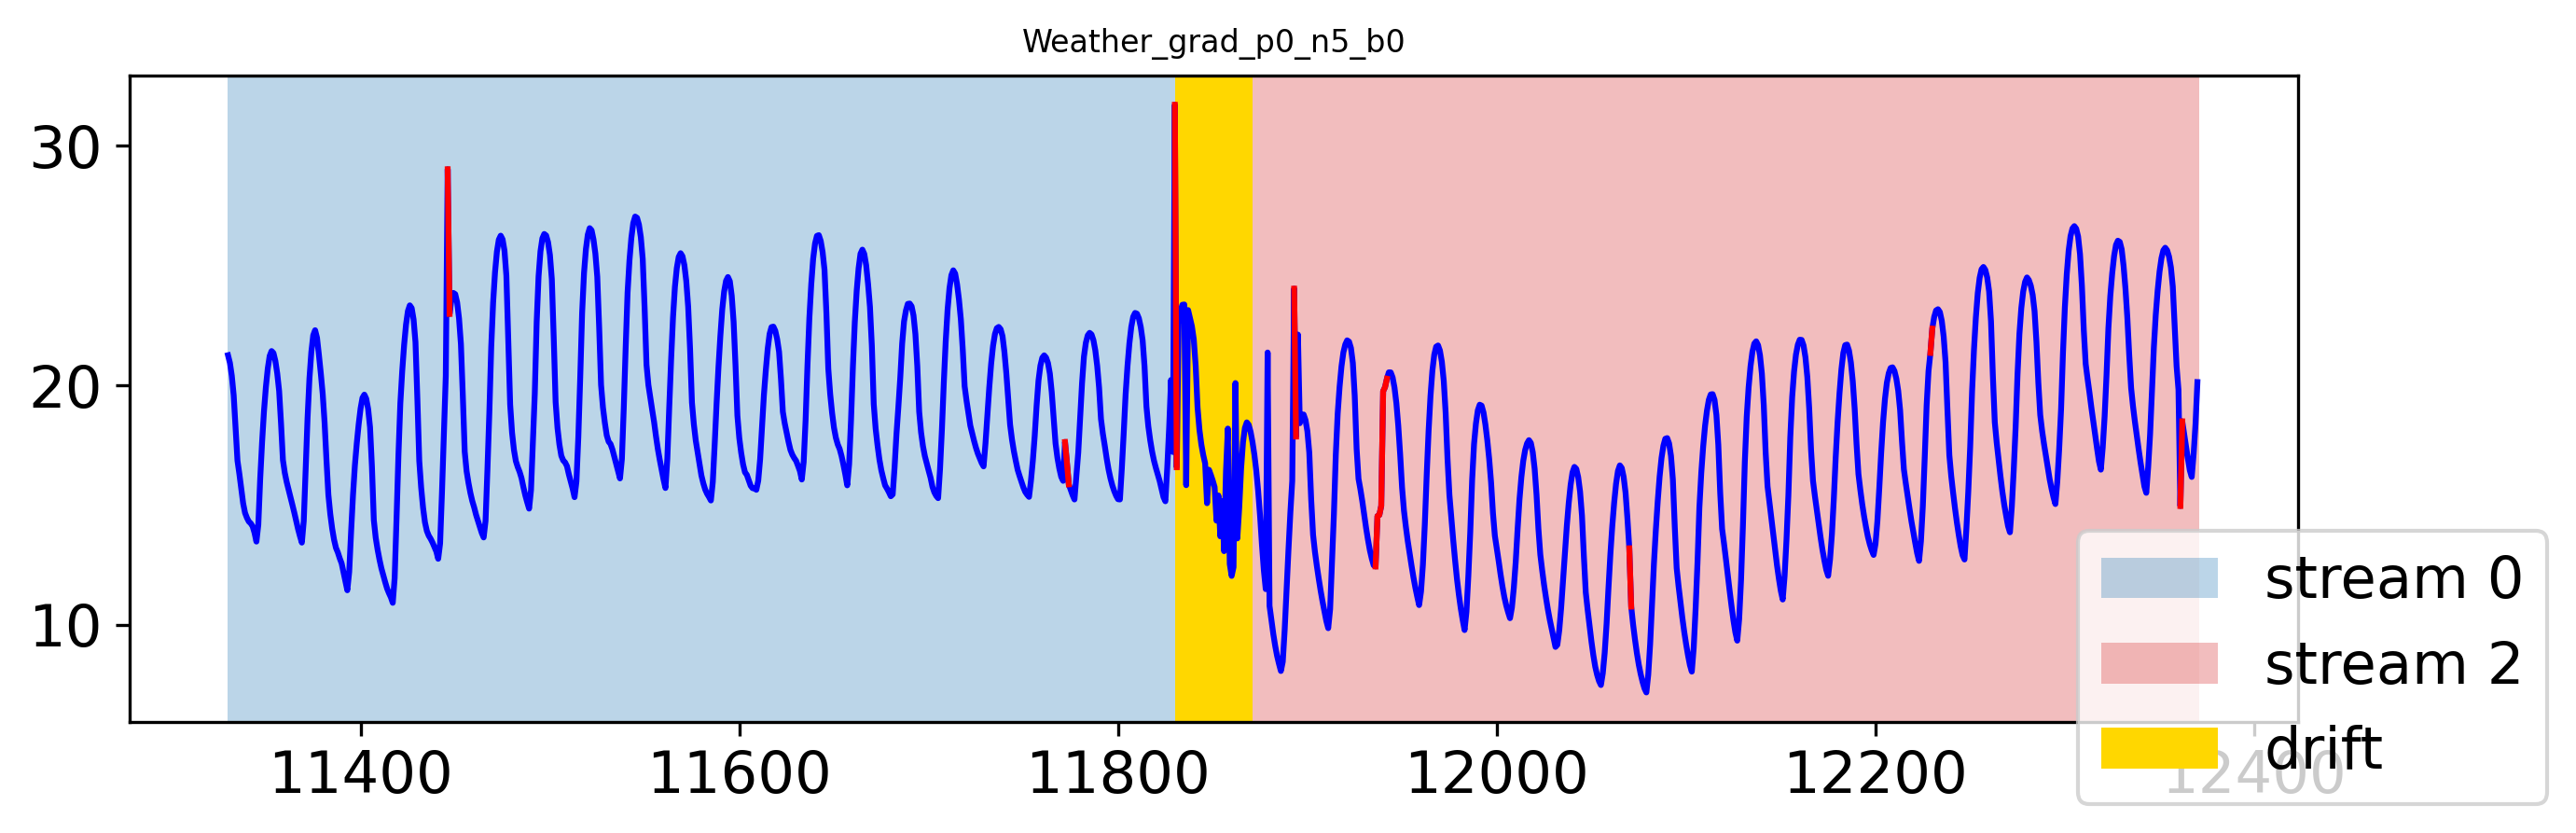

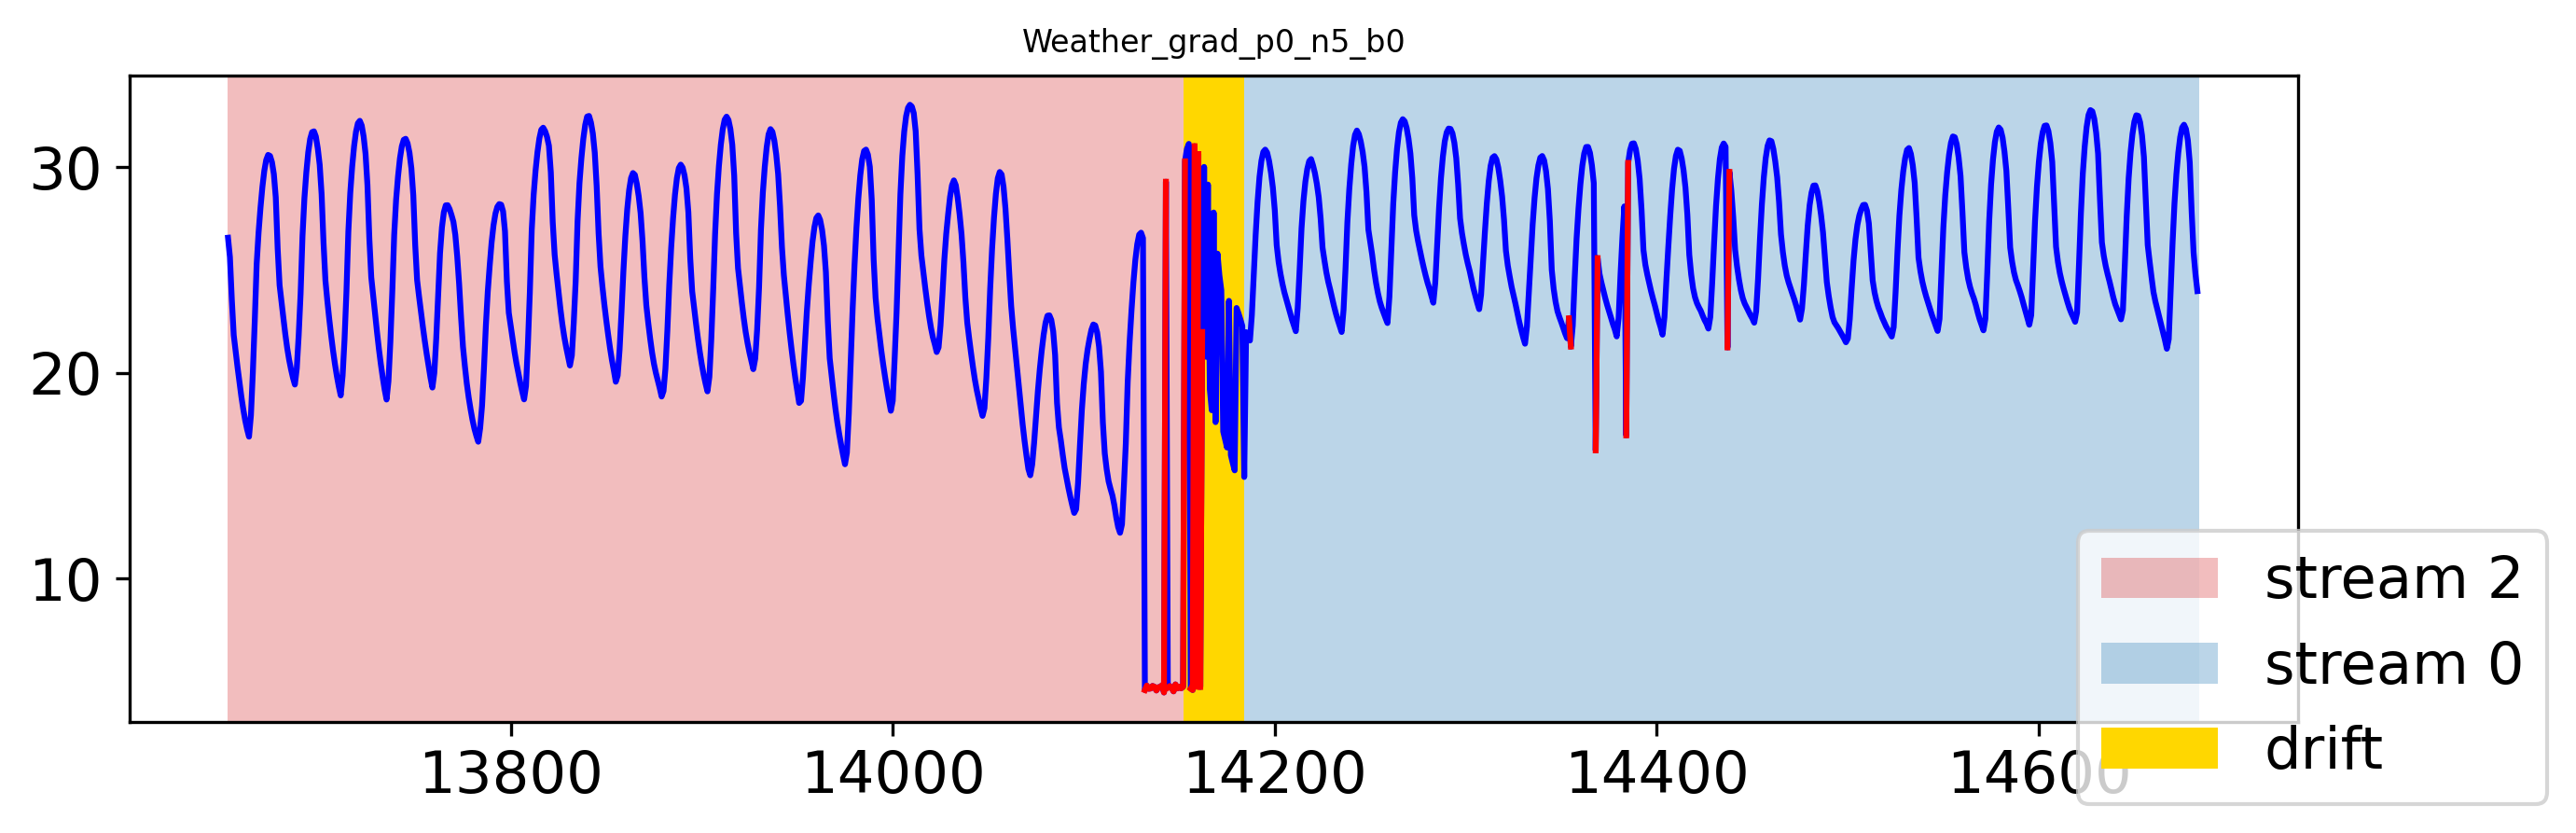

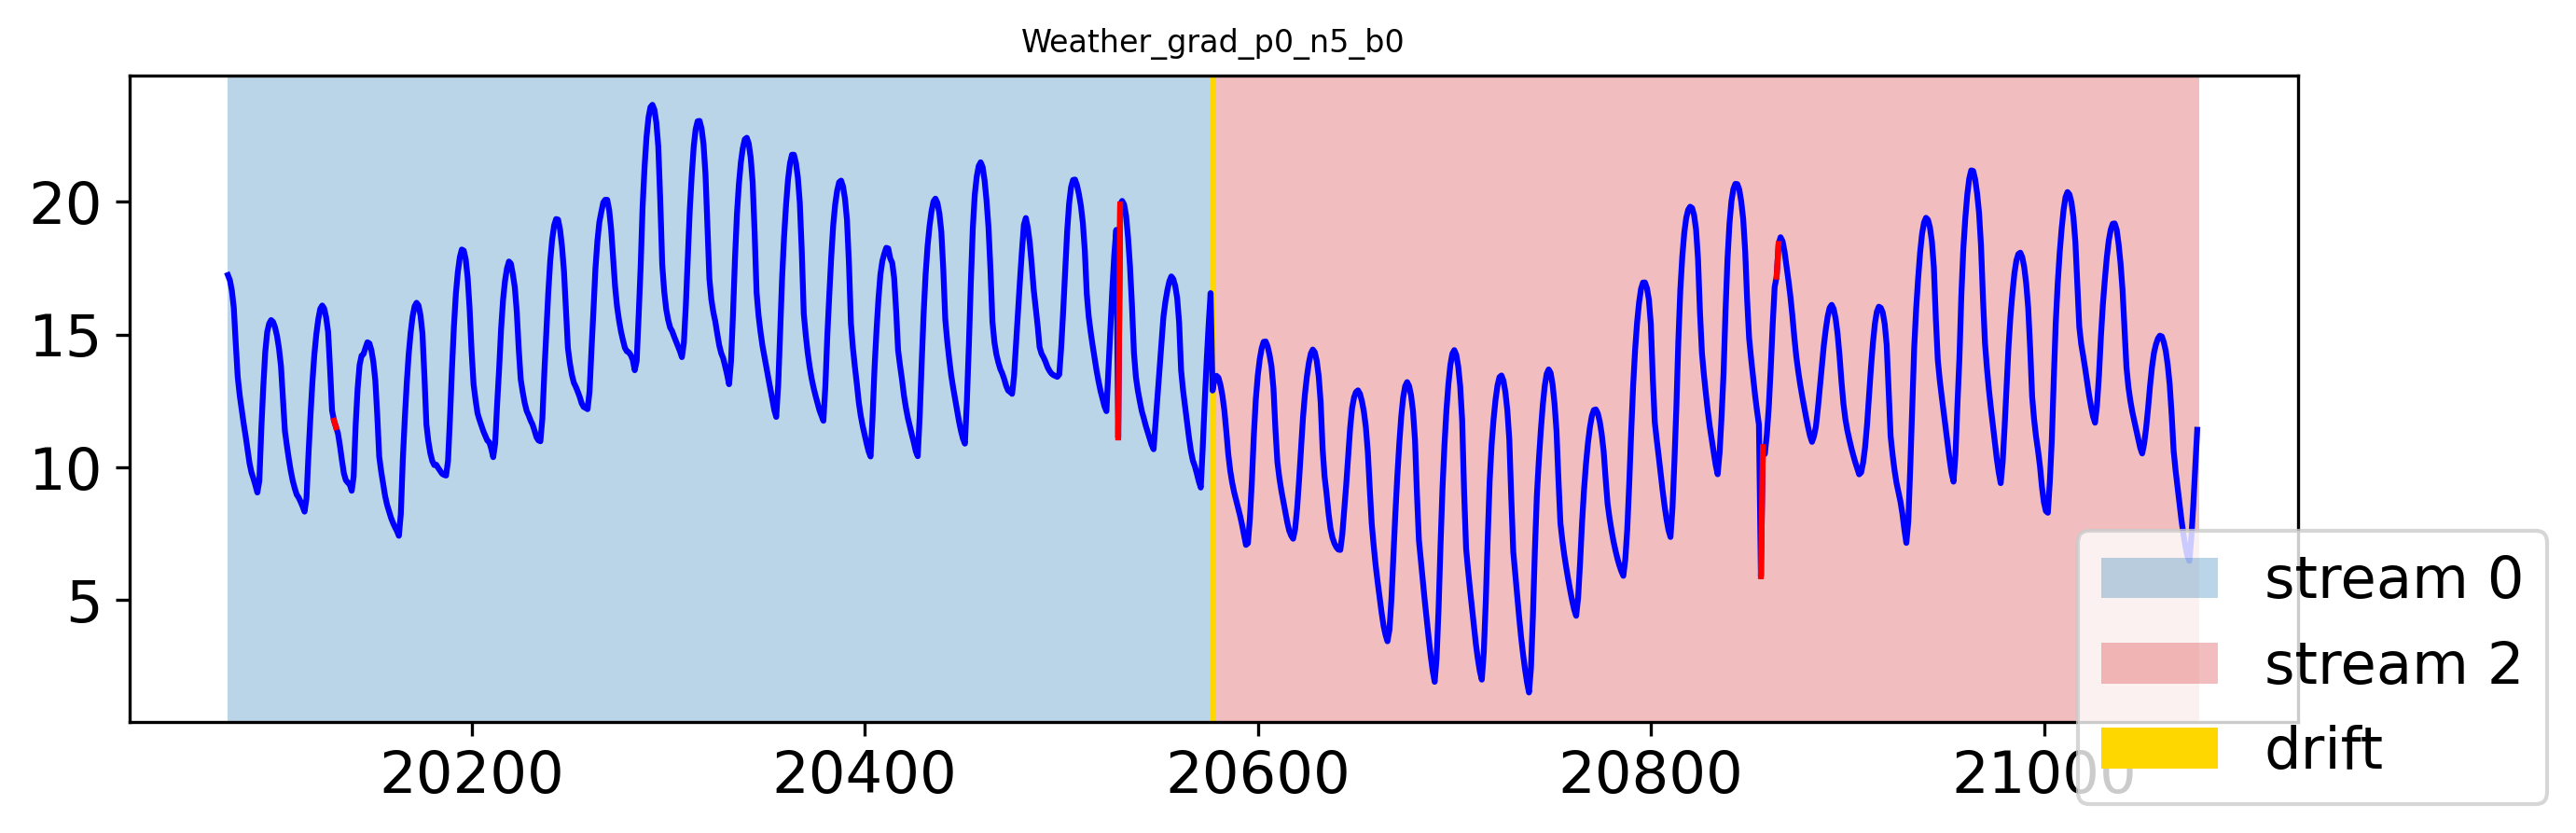

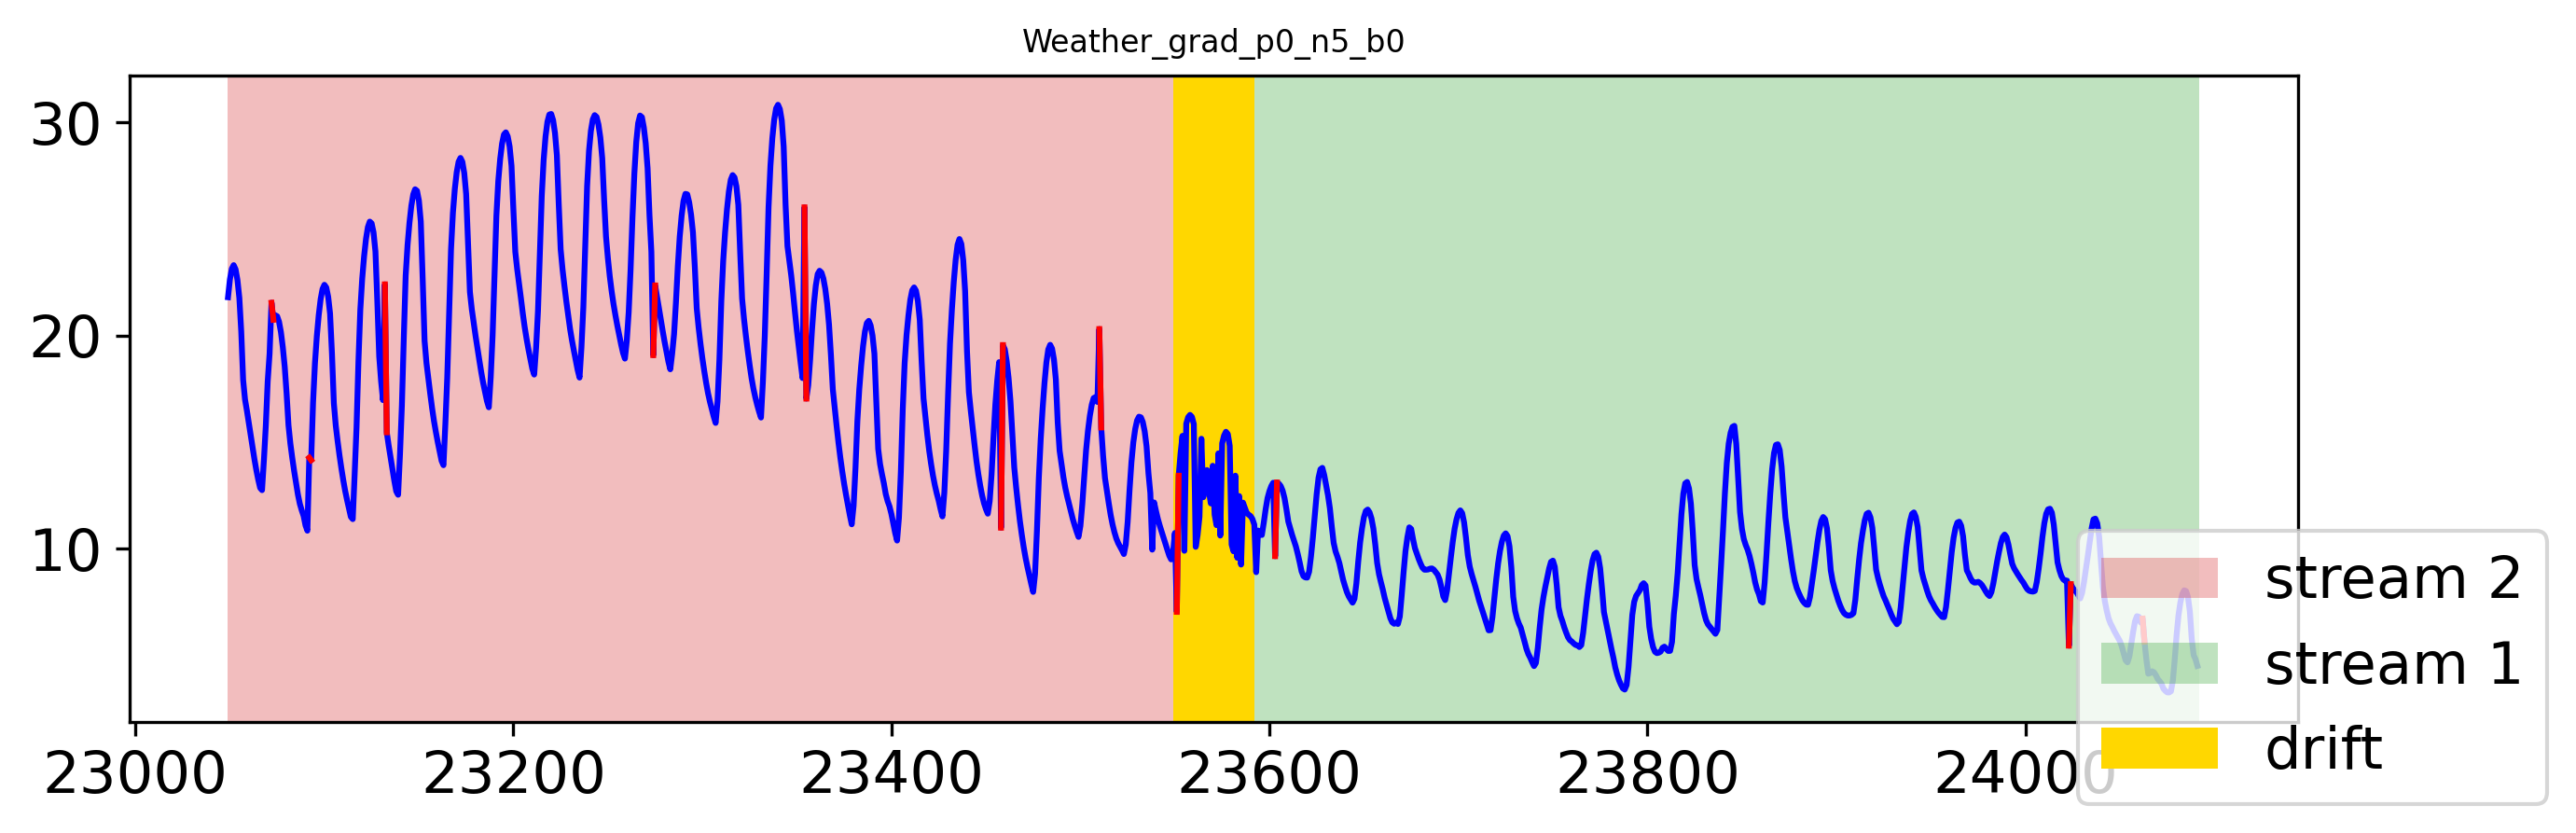

In [7]:
for drift_interval in ds.drift_intervals:
    ds.plot_drift(drift_interval[0]-500, drift_interval[1]+500)